In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import h5py
import pandas as pd
import csv

import innvestigate

from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

from utils import load_nifti, normalize_float, IntensityRescale, replace_classifier
from plotting import *
from config import *

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [139]:
keras.__version__

'2.2.2'

In [140]:
tf.__version__

'1.11.0'

In [5]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/"

In [6]:
# load hdf5 files and extract columns
#train_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset.h5', 'r')
#holdout_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset.h5', 'r')

#X_train, y_train = train_h5['X'], train_h5['y']
#X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

# load hdf5 including edss
train_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_with_edss.h5', 'r')
holdout_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_with_edss.h5', 'r')

X_train, y_train, edss_train = train_h5['X'], train_h5['y'], train_h5["edss"]
X_holdout, y_holdout, edss_holdout = holdout_h5['X'], holdout_h5['y'], holdout_h5["edss"]

train_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [7]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [8]:
# load downsampled atlases
atlas_labels_path = "/analysis/fabiane/scaled_nmm_order0.nii"
atlas_labels = load_nifti(atlas_labels_path)

wm_atlas_path = "/analysis/fabiane/scaled_JHU_WM_order0.nii"
wm_atlas = load_nifti(wm_atlas_path)

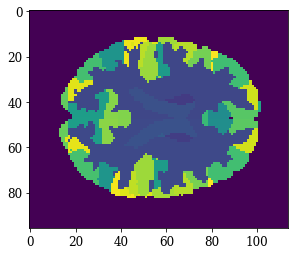

In [9]:
plt.imshow(atlas_labels[:,:,48])
plt.show()

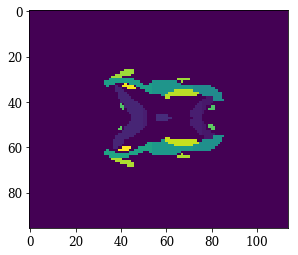

In [10]:
plt.imshow(wm_atlas[:,:,48])
plt.show()

In [11]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None, include_arbtr=False, **kwargs):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        self.include_arbtr = include_arbtr
        if include_arbtr:
            self.kwargs = kwargs["edss"]
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        if not self.include_arbtr:
            return image, label
        else:
            arbtr = self.kwargs[idx * self.batch_size:(idx + 1) * self.batch_size]
            return image, label, arbtr
    
    def on_epoch_end(self):
        if self.shuffle:
            if not self.include_arbtr:
                self.X, self.y = shuffle(self.X, self.y)
            else:
                self.X, self.y, self.kwargs = shuffle(self.X, self.y, self.kwargs)

## Make dataset

In [12]:
intensity = IntensityRescale(masked=False)

In [13]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


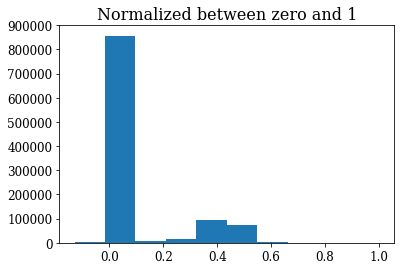

In [14]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


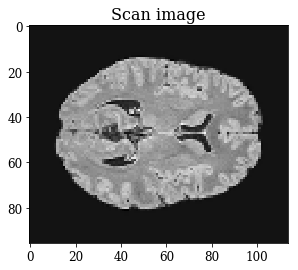

In [15]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

In [16]:
lesion_masks_train.shape

(124, 96, 114, 96)

# Model

In [17]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [18]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model_path = "/analysis/fabiane/models/ADNI/explMS/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [19]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [20]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [21]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


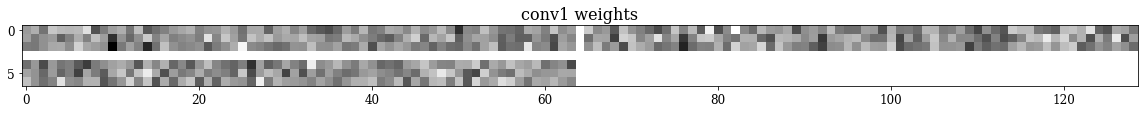

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.00011376218753866851


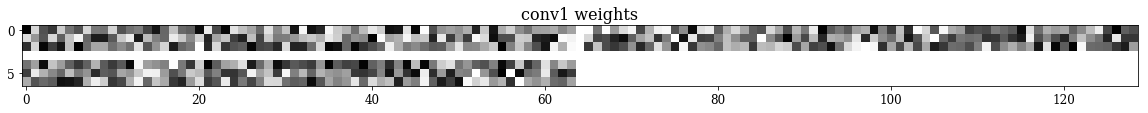

In [22]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

# Visualization

In [23]:
def plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis):
    r = 2
    c = 2
    # Displaying the gradient
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(hspace=0.15, wspace=0.)
    ax1 = plt.subplot(r, c, 1)
    plt.imshow(X_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Scan")
    ax2 = plt.subplot(r, c, 2)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Lesion mask")
    ax3 = plt.subplot(r, c, 3)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='Reds', alpha=0.6, vmin=0.1)
    plt.title("Lesion mask over scan")
    ax4 = plt.subplot(r, c, 4)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(analysis.squeeze()[:,:,sl], cmap='Reds', interpolation='nearest', alpha=0.6)
    plt.title("Heatmap overlayed")
    plt.show()

In [24]:
num_trials = 10
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [25]:
import keras.layers
import keras.models
import keras.utils

import innvestigate.utils as iutils

In [26]:
model = load_model(model_path)
#model = replace_classifier(model, activation='tanh', units=1)
model = replace_classifier(model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[5]) # select best model
#model_dir = os.path.join(result_dir, weights[1]) # select other model
model.load_weights(model_dir)

In [27]:
image_idx = 8
sl = 48
b = 1
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=b, shuffle=False, z_factor=z_factor)
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [28]:
print(label)

[1]


In [29]:
image.shape

(1, 96, 114, 96, 1)

In [30]:
pred = model.predict(image)
print("Model prediction: {} with final output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 1 with final output: 3.5993


In [31]:
lesion_masks_holdout.shape

(23, 96, 114, 96)

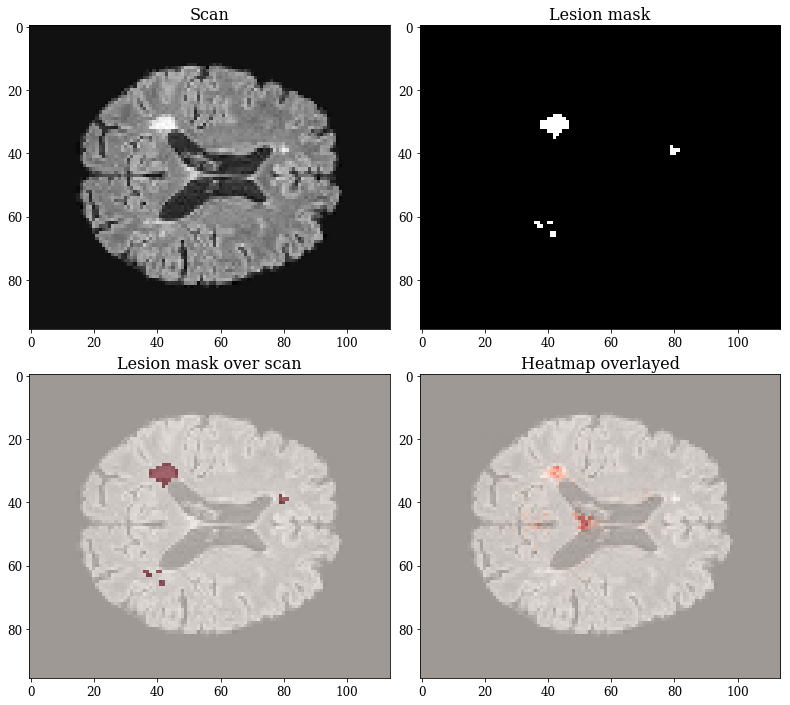

In [32]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [33]:
def heatmap_lesion_similarity(heatmap, lesions, intensity=True, plot=False):
    assert(heatmap.shape == lesions.shape)
    hm = np.copy(heatmap)
    hm = heatmap/np.max(heatmap)
    sl = 48
    if not intensity:
        #thresh = np.max(heatmap)/20
        # threshold hard to fix.. better use with intensities
        thresh = np.max(heatmap)/(6)
        #thresh = 1e-4
        hm[np.where(heatmap>thresh)] = 1.
        hm[np.where(heatmap<=thresh)] = 0.
    if plot:
        plt.imshow(hm[:,:,sl], cmap='gray')
        plt.show()
    l = lesions * hm
    similarity = np.sum(l)
    if not intensity:
        similarity /= np.sum(lesions)
    return similarity

In [34]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

114.81796539925472


In [35]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

0.21434820647419073


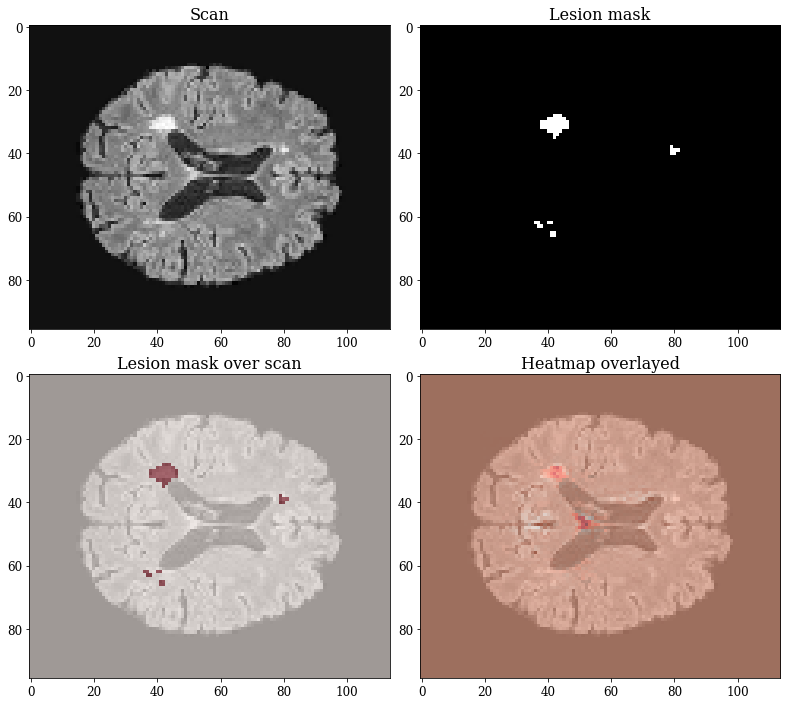

In [36]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

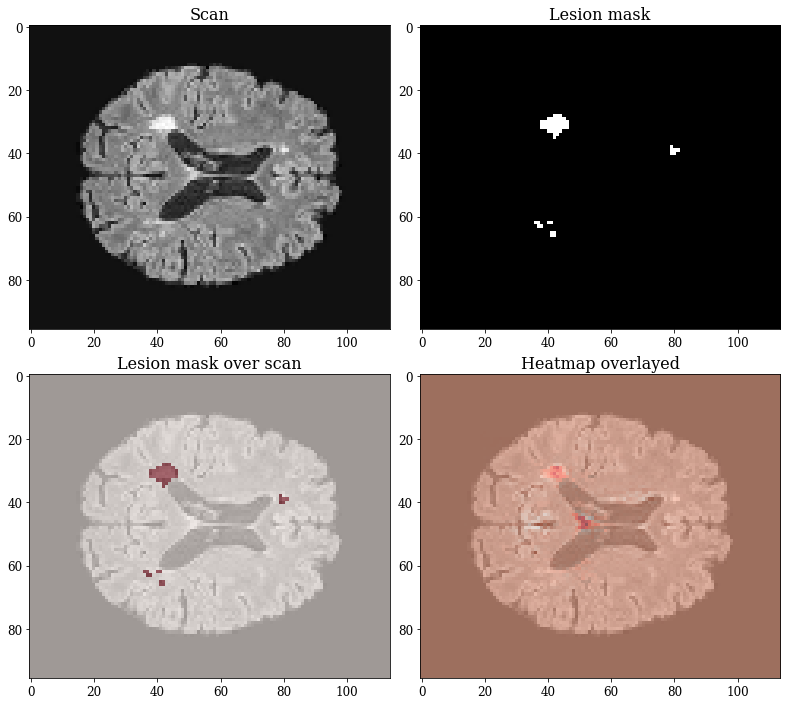

In [37]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

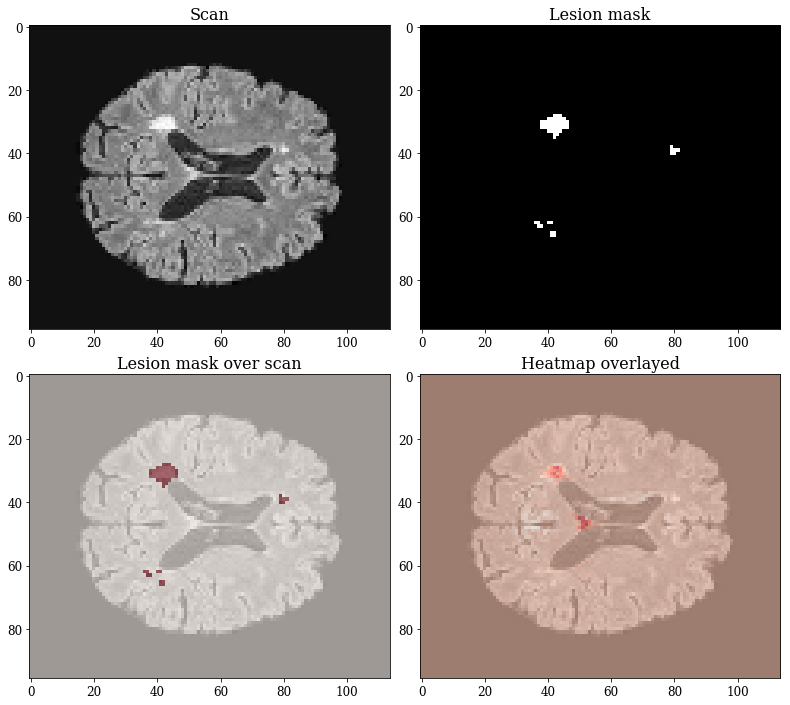

In [38]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

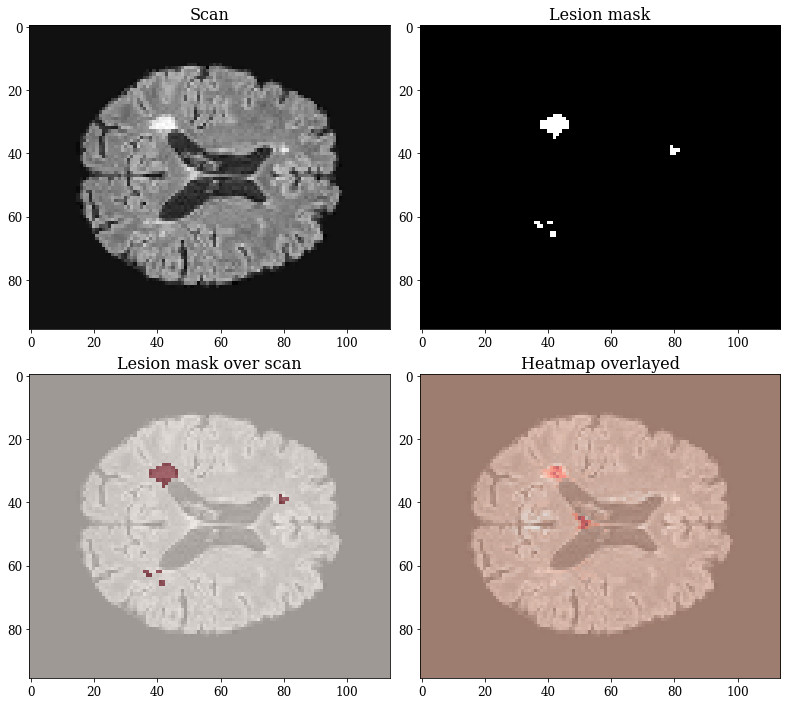

In [39]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [40]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

48.356564072470974
0.1452318460192476


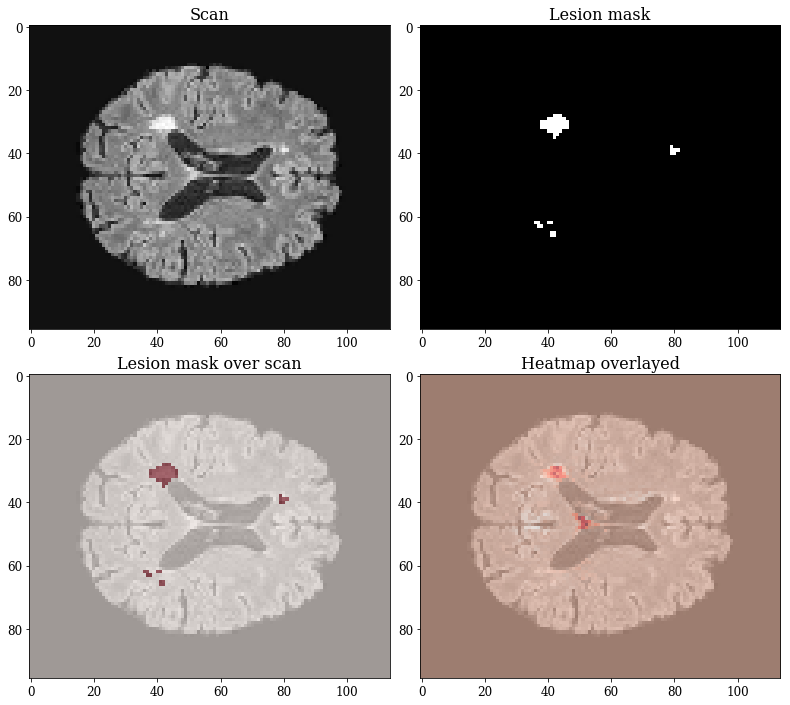

In [41]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=0.001)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [42]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

48.17674544711463
0.1426071741032371


## Using only the pre-trained model / no fine-tuning

In [43]:
# loading pre-trained model
model = load_model(model_path)
model = replace_classifier(model, activation=None, units=1)

In [44]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [45]:
print(label)

[1]


In [46]:
pred = model.predict(image)
print("Model prediction: {} with final simgoid output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 0 with final simgoid output: -2.3429


In [47]:
image.shape

(1, 96, 114, 96, 1)

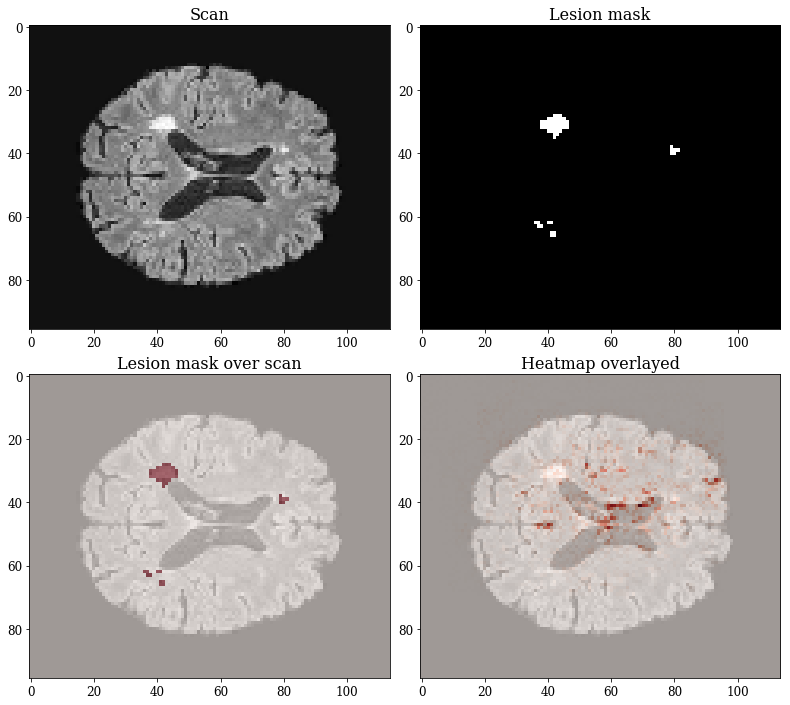

In [48]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [49]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

25.604735343020366


In [50]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

0.01399825021872266


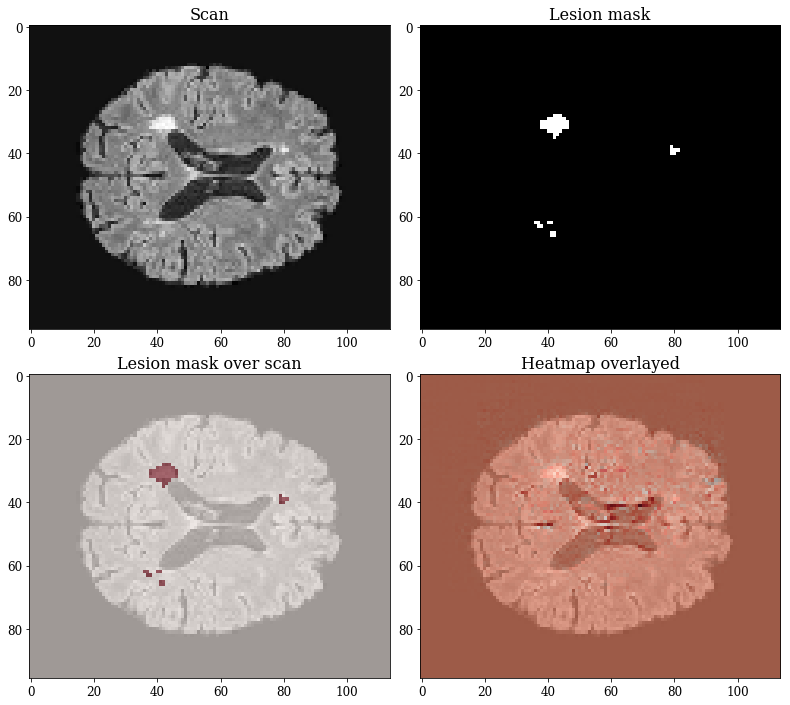

In [51]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

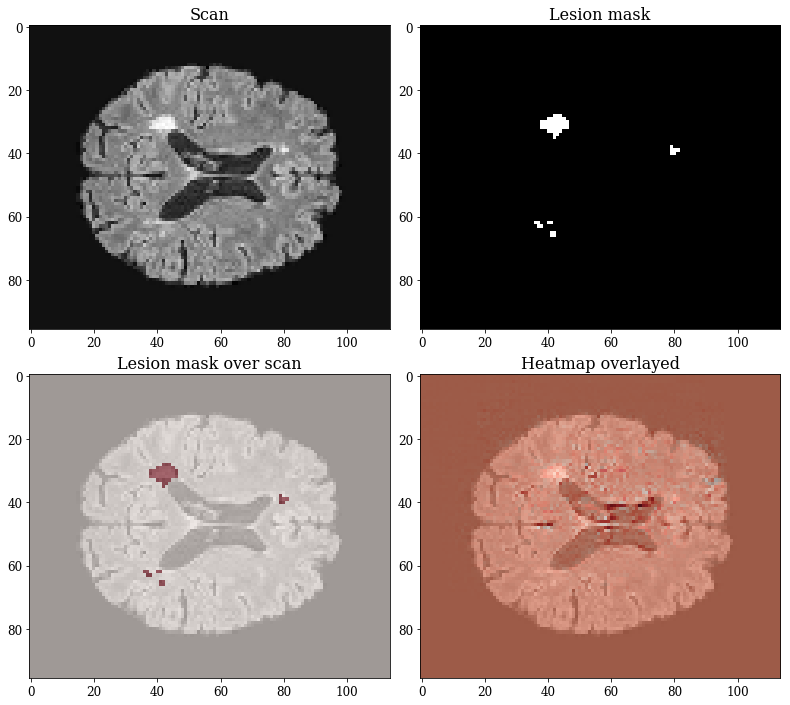

In [52]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

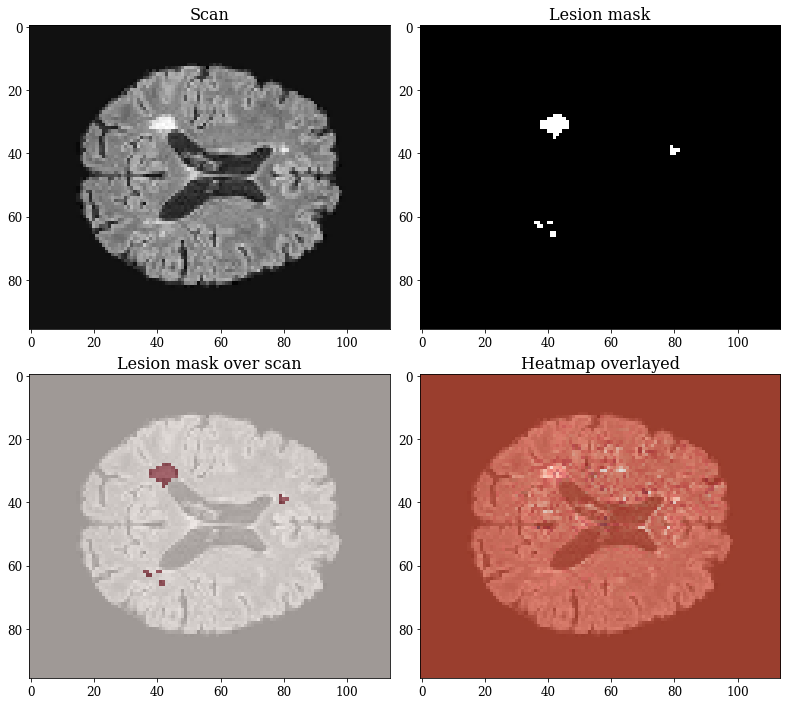

In [53]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

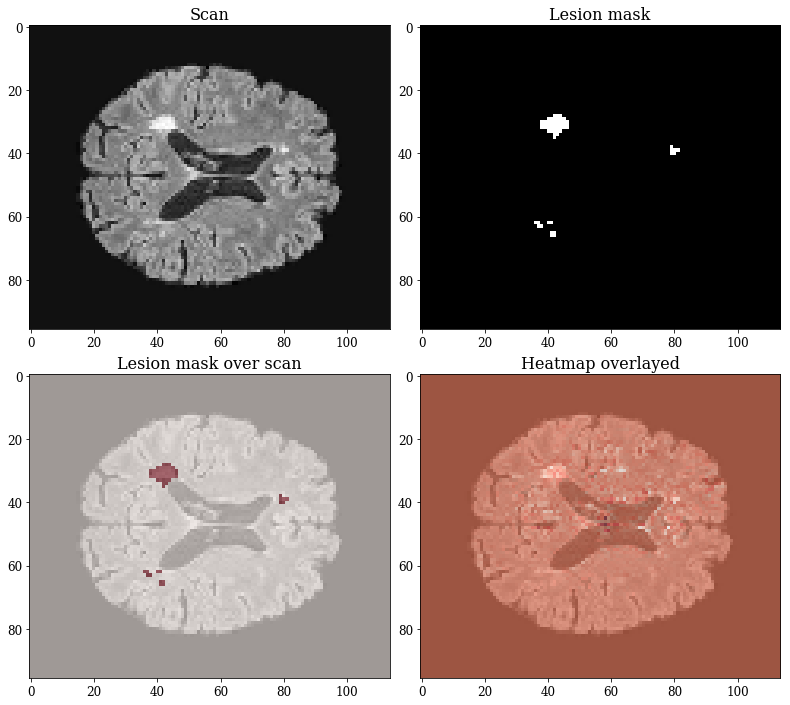

In [54]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

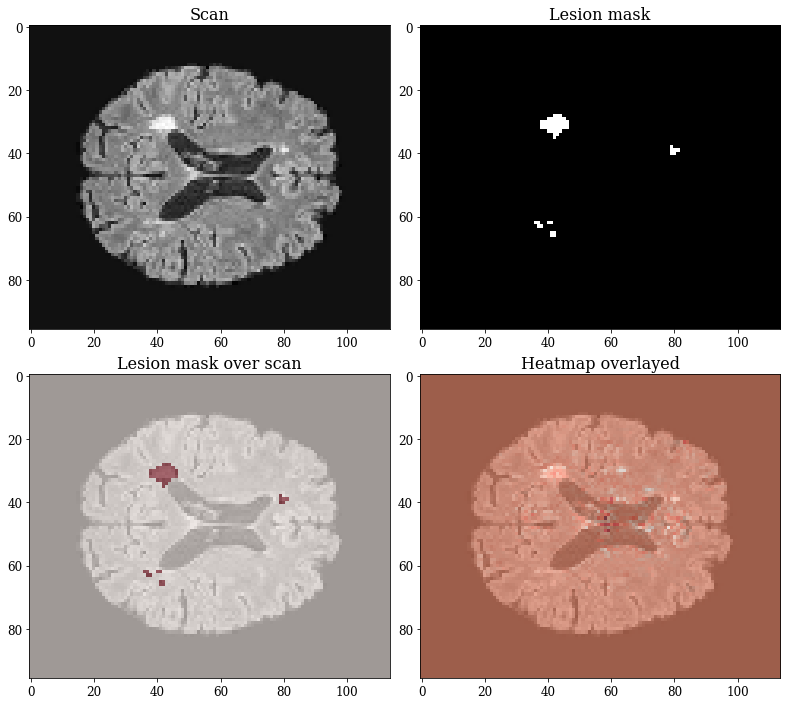

In [55]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

## Random weights

In [56]:
# use random weights
model = load_model(model_path)
reset_weights(model)

In [57]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [58]:
print(label)

[1]


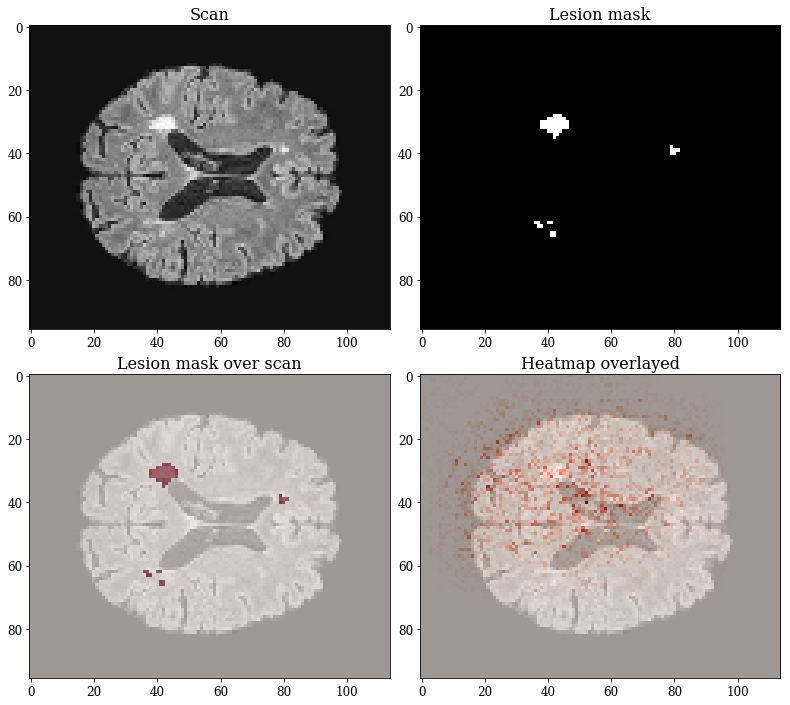

In [59]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [60]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

109.19770606825841


In [61]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

0.16447944006999124


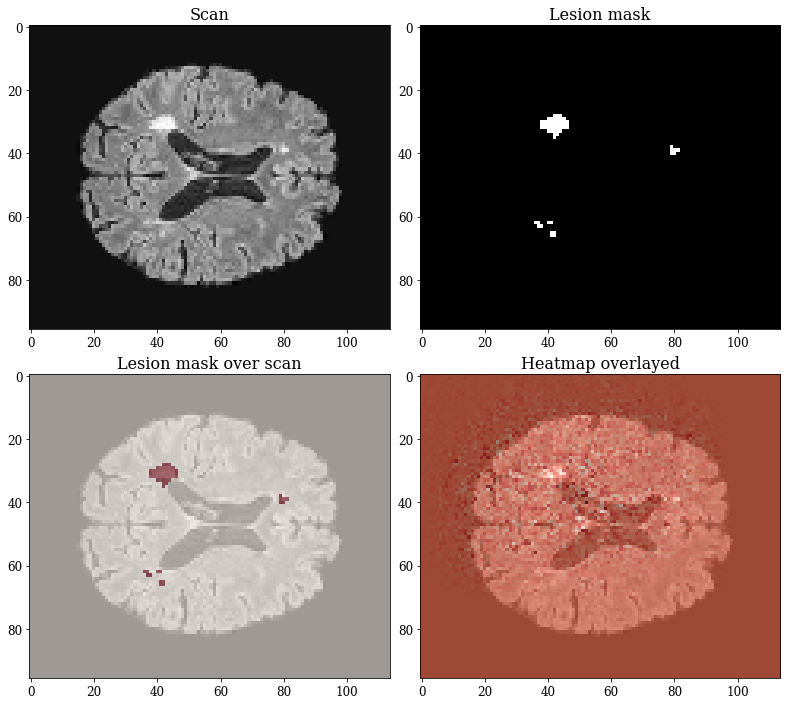

In [62]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

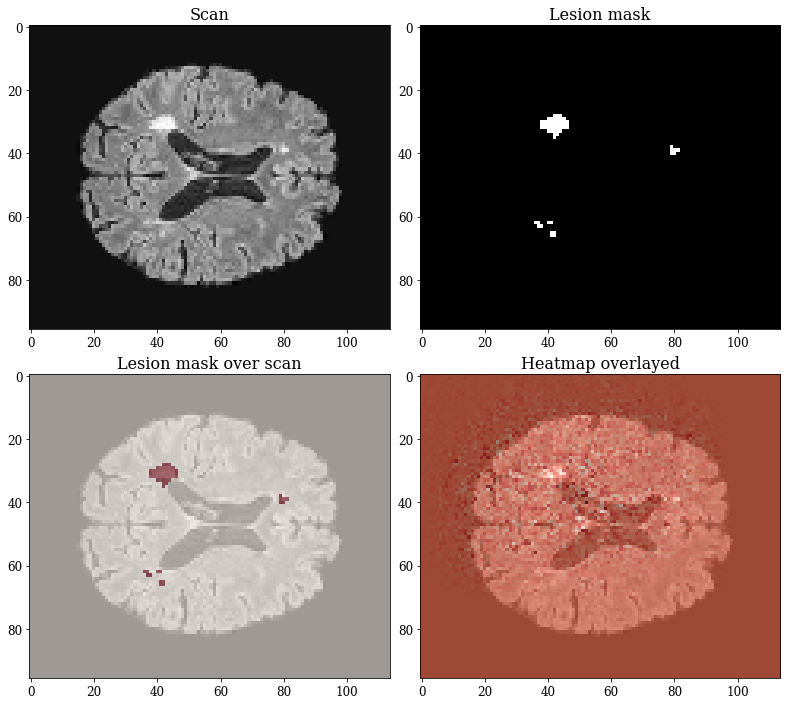

In [63]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

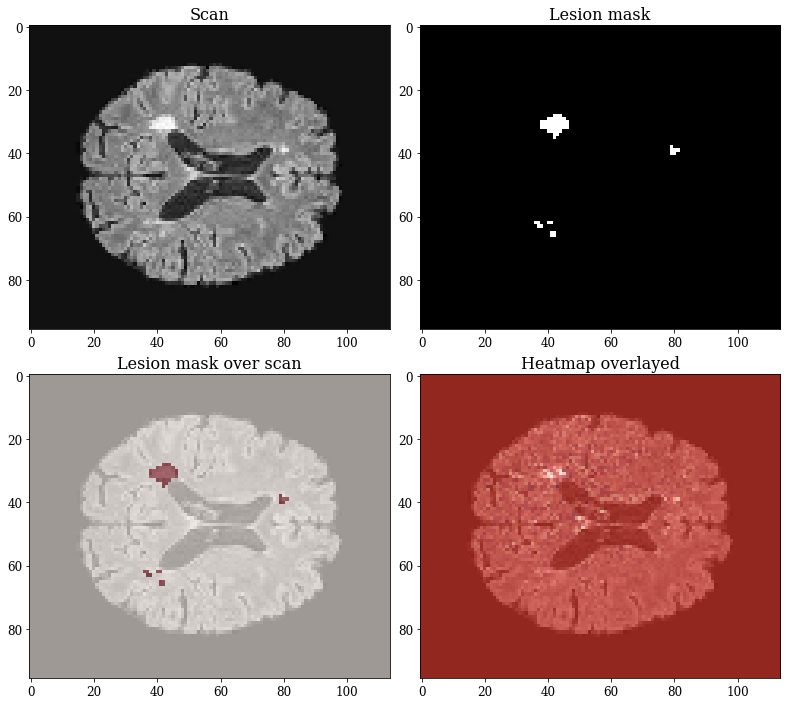

In [64]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

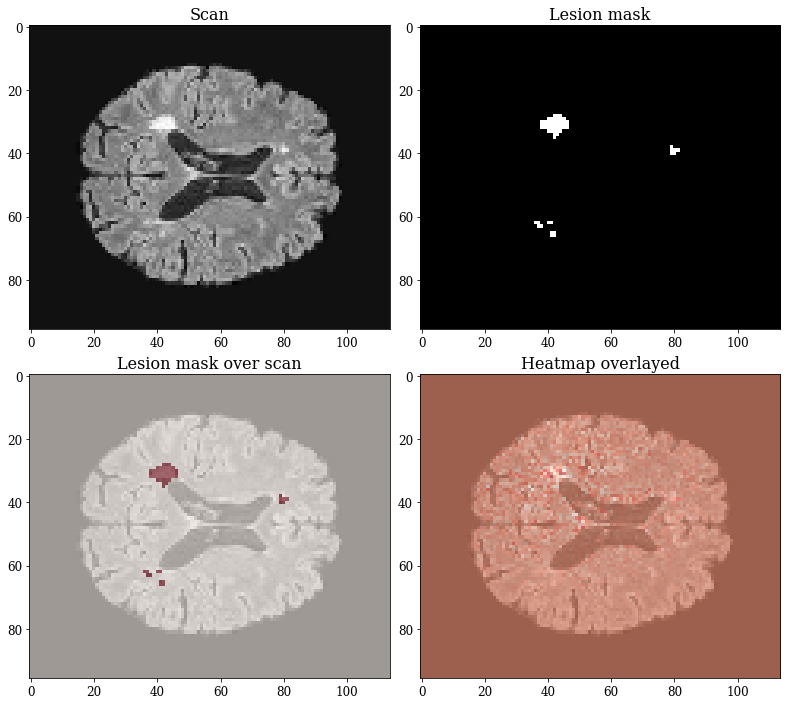

In [65]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

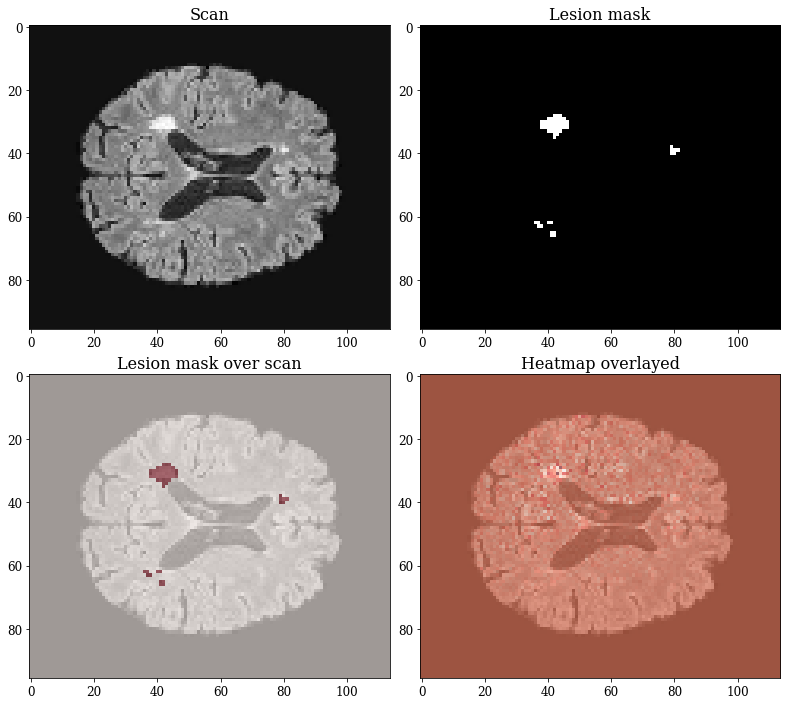

In [66]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

# Main part

### Loading different models

In [67]:
# pre-trained model
pre_trained_model = load_model(model_path)
pre_trained_beheaded_model = replace_classifier(pre_trained_model, activation=None, units=1) # use logits

# fine-tuned model
fine_tuned_model = load_model(model_path)
fine_tuned_beheaded_model = replace_classifier(fine_tuned_model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[5]) # select best model
fine_tuned_beheaded_model.load_weights(model_dir)
fine_tuned_model.load_weights(model_dir)

# trained from scratch model
scratch_model = load_model(model_path)
scratch_beheaded_model = replace_classifier(scratch_model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, "MS_from_scratch", weights[2]) # select best model
scratch_beheaded_model.load_weights(model_dir)
scratch_model.load_weights(model_dir)

# un-trained model
random_model = load_model(model_path)
random_beheaded_model = replace_classifier(random_model, activation=None, units=1) # use logits
reset_weights(random_beheaded_model)
reset_weights(random_model)

### Creating special transparent colormap

In [68]:
from matplotlib.colors import LinearSegmentedColormap
def generate_transparanet_cm(base='coolwarm'):
    # copy from existing colormap
    ncolors = 256
    color_array = plt.get_cmap(base)(range(ncolors))

    # create parabolic decrease 
    decr = [-1*(x**2)+1 for x in range(int(ncolors/2))]
    # normalize
    decr = (decr - np.min(decr))/(np.max(decr - np.min(decr)))

    # use inverted parabola as increase
    incr = np.copy(decr)[::-1]
    alphas = np.concatenate((decr, incr))
    # update alpha values
    color_array[:,-1] = alphas

    # create new colormap and register it
    transparent_coolwarm = LinearSegmentedColormap.from_list('TransCoWa', color_array)
    plt.register_cmap(cmap=transparent_coolwarm)

In [91]:
generate_transparanet_cm(base='coolwarm')

### Plotting functions

In [69]:
image_file_dir = "/analysis/fabiane/documents/publications/MS_CNN_VIS"

In [70]:
mask = np.expand_dims(load_nifti("/analysis/ritter/data/MS/Test/alt/zoomed_mask2.nii.gz", z_factor=z_factor), 3)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [71]:
mask[mask <1e-5] = 0.0

In [72]:
test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [73]:
train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [74]:
def plot_heatmap(heatmap, scan_avg, vmin, vmax, title="Heatmap sum", cmap='seismic', sl=(48, 60, 48), show_average=True):
    vmin = -0.05
    vmax = 0.05
    #vmax = vmin * -1
    #vmin = np.min(heatmap)
    #vmax = np.max(heatmap)
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,:,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 2)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 3)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[sl[2],:,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.show()

In [75]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap2(heatmap, scan_avg, vmin, vmax, title=None, cmap='seismic', sl=((48, 60, 48),), show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of entire individual by iterating over
    slice combinations.
    """
    vmin = -0.03
    vmax = 0.03
    sl_list = list(sl)
    nrows = len(sl_list)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.49, 4.5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]

    for count, sl in enumerate(sl_list):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.05, 0.01, p2[2], 0.01]) # settings for whole subject
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)   
        
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [76]:
def plot_heatmap_zero_one(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.08, 0.07, p2[2], 0.03]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
    
    
    # ensure colorbar is within plot
    #fig.subplots_adjust(bottom=0.2)
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [77]:
from decimal import *

In [78]:
def get_heatmap_sum(dataloader, shape, beheaded_model, prediction_model, mode='prediction', as_list=False):
    """
    Return the total heatmap sum of all subjects within the dataset.
    In the code "one_" stands for prediction class and "zero_" for null class.
    
    Arguments
        mode: Can be one of 'prediction' or 'label'. Former separates
            true positives and true negatives (ignores false
            predictions), latter separates only by label.
        
    """
    if not as_list:
        one_heatmaps = np.zeros(shape=shape)
        zero_heatmaps = np.zeros(shape=shape)
    else:
        one_heatmaps = []
        zero_heatmaps = []
        
    def add_hm(hm, analysis):
        if not as_list:
            hm += analysis
        else:
            hm.append(analysis)
            
    one_count = 0
    zero_count = 0
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        pred = (prediction_model.predict(image) > 0.5) * 1.

        # Applying the analyzer
        analysis = gradient_analyzer.analyze(image)
        
        if mode == 'prediction':
            # Sorting by correct predictions
            if label == 1 and pred == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 0 and pred == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        elif mode == 'label':
            # Sorting by label
            if label == 1:
                add_hm(one_heatmaps, analysis)
                one_count += 1
            elif label == 0:
                add_hm(zero_heatmaps, analysis)
                zero_count += 1
        
    print("Sorted by {}".format(mode))
    print("total {}".format(len(dataloader)))
    print("one {}".format(one_count))
    print("zero {}".format(zero_count))
    # Average values over number of samples
    if not as_list:
        one_heatmaps /= one_count
        zero_heatmaps /= zero_count
    
    return one_heatmaps, zero_heatmaps

In [79]:
def get_heatmap_list(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
    return heatmap_list

In [80]:
def get_heatmap_list_with_edss(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    edss = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        edss_score = dataloader[image_idx][2][[0]].item()
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
            edss.append(edss_score)
    return heatmap_list, edss

# Average heatmaps

In [82]:
ms_heatmaps_holdout, hc_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [83]:
ms_heatmaps_train, hc_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 124
one 63
zero 61


In [84]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [85]:
TP_heatmaps_train, TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 124
one 54
zero 60


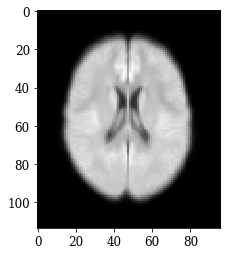

In [86]:
# Create average image for background
avg_train_image = np.mean(X_train, axis=0)
plt.imshow(np.rot90(np.squeeze(avg_train_image)[:,:,48], axes=(0,1)), cmap='gray')
plt.show()

# Holdout averages

### MS vs HC

In [87]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

In [88]:
plt.rc('font', family='serif')

In [89]:
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['serif']))
print(font)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


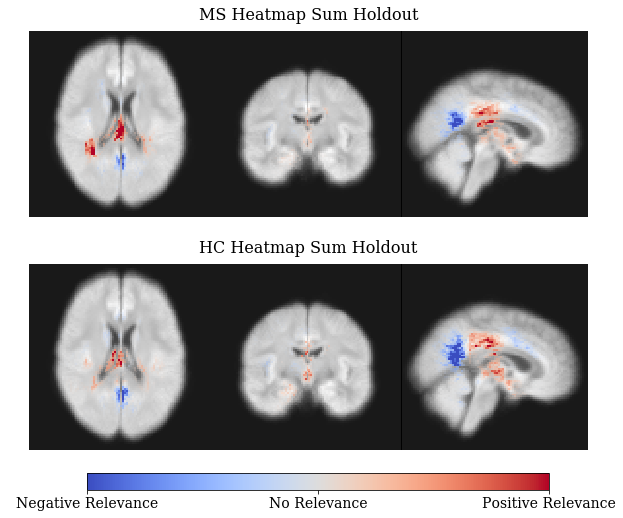

In [92]:
hms = [ms_heatmaps_holdout, hc_heatmaps_holdout]
titles = ["MS Heatmap Sum Holdout", "HC Heatmap Sum Holdout"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

### TP vs TN

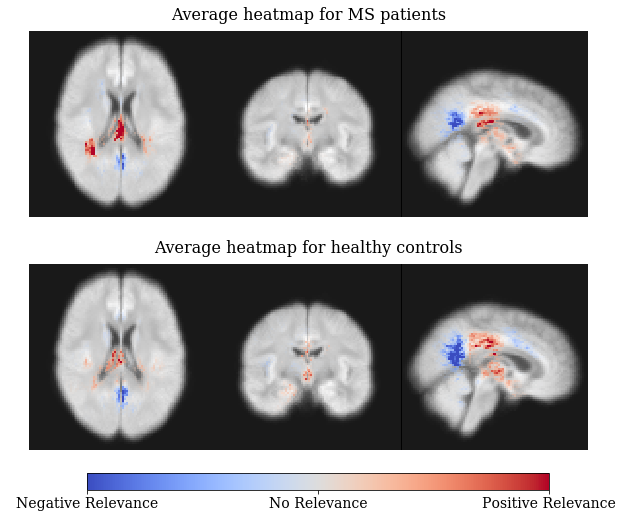

In [95]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
titles = ["Average heatmap for MS patients", "Average heatmap for healthy controls"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_TP_TN_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

# Atlas analysis

## Gray matter atlas

In [97]:
keys, values = get_area_relevance(hms, atlas_labels, gm_areas, positive=True, size_normalize=False)

In [98]:
keys = translate_keys(keys)
df = wrap_as_df(keys, values)
short_df = reduce_df(df, take=30)

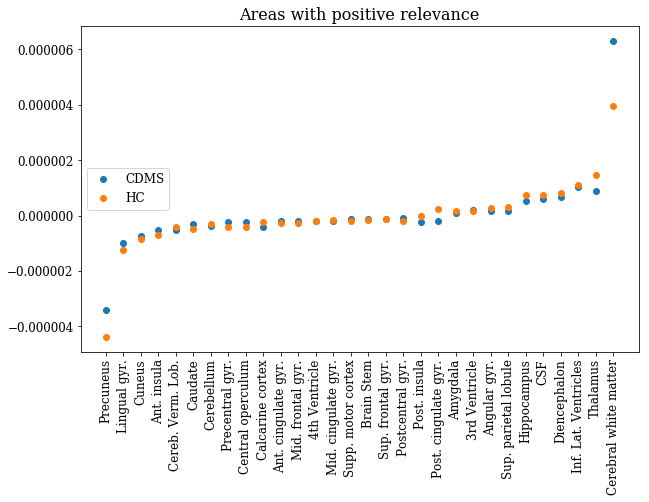

In [99]:
plot_dataframe(short_df, "Areas with positive relevance")

Values normalized

In [102]:
norm_keys, norm_values = get_area_relevance(hms, atlas_labels, gm_areas, positive=True, size_normalize=True)

In [103]:
norm_keys = translate_keys(norm_keys)
norm_df = wrap_as_df(norm_keys, norm_values)
short_norm_df = reduce_df(norm_df, take=30)

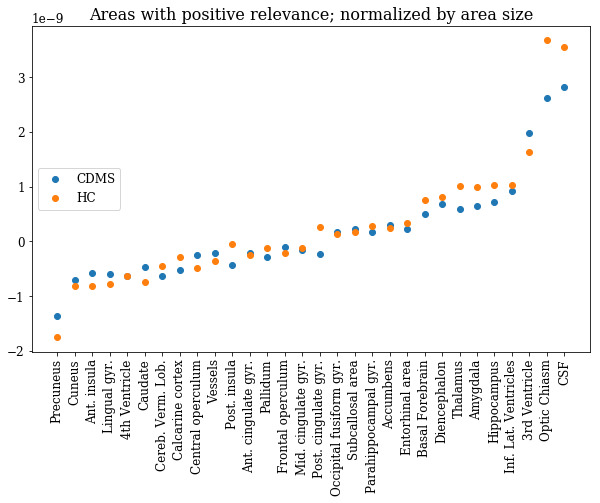

In [104]:
plot_dataframe(short_norm_df, "Areas with positive relevance; normalized by area size")

### Subject wise atlas analysis

In [115]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=True)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=True)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]
            
df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)            

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [116]:
print(np.sum(TP_heatmaps_holdout_list))
print(np.mean(TP_heatmaps_holdout_list))
print(np.std(TP_heatmaps_holdout_list))

38.732124
3.0721524e-06
0.0013698384


In [117]:
print(np.sum(TN_heatmaps_holdout_list))
print(np.mean(TN_heatmaps_holdout_list))
print(np.std(TN_heatmaps_holdout_list))

-9.914864
-1.0485687e-06
0.0012700517


In [118]:
short_df_TN, short_df_TP = reduce_two_dfs(df_TN, df_TP, take=30)

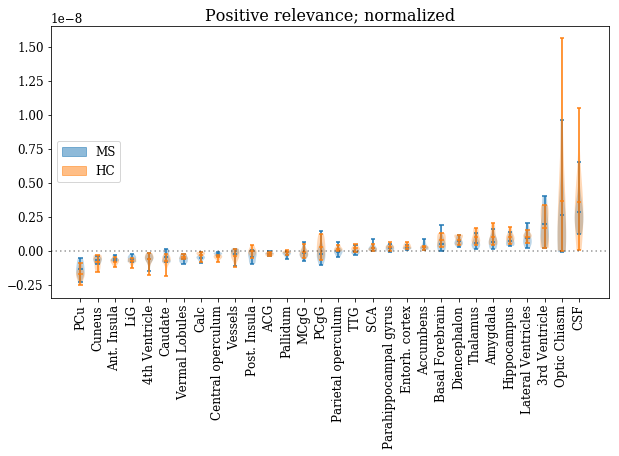

In [119]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)

axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
plt.show()

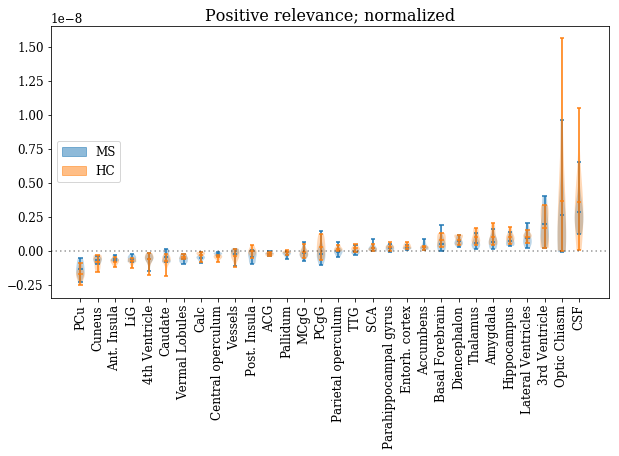

In [120]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)

axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
plt.show()

Not normalized

In [121]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=False)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, atlas_labels, gm_areas, positive=True, size_normalize=False)

keys_TP = translate_keys(keys_TP)
hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]
            
keys_TN = translate_keys(keys_TN)
hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]

df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)        

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [123]:
short_df_TN, short_df_TP = reduce_two_dfs(df_TN, df_TP, take=30)

In [124]:
len(short_df_TP.columns)

30

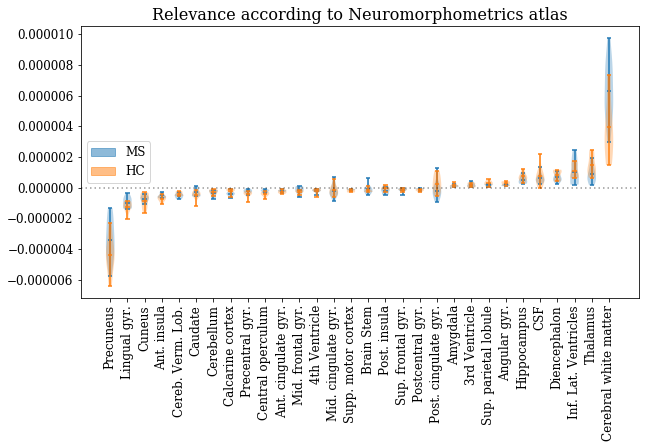

In [127]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[short_df_TP[column].values for column in short_df_TP.columns], showmeans=True)
axes.violinplot(dataset=[short_df_TN[column].values for column in short_df_TN.columns], showmeans=True)
#axes.violinplot(dataset=short_df_TN, showmeans=True)


axes.set_xticks(range(1, len(short_df_TP.columns)+1))
axes.set_xticklabels(short_df_TP.columns.values)
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Relevance according to Neuromorphometrics atlas")
file_path = os.path.join(image_file_dir, "relevance_GM_normal-scans_absolute.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
plt.show()

## White matter atlas

Positive

In [129]:
keys, values = get_area_relevance(hms, wm_atlas, wm_areas, positive=True, size_normalize=False)

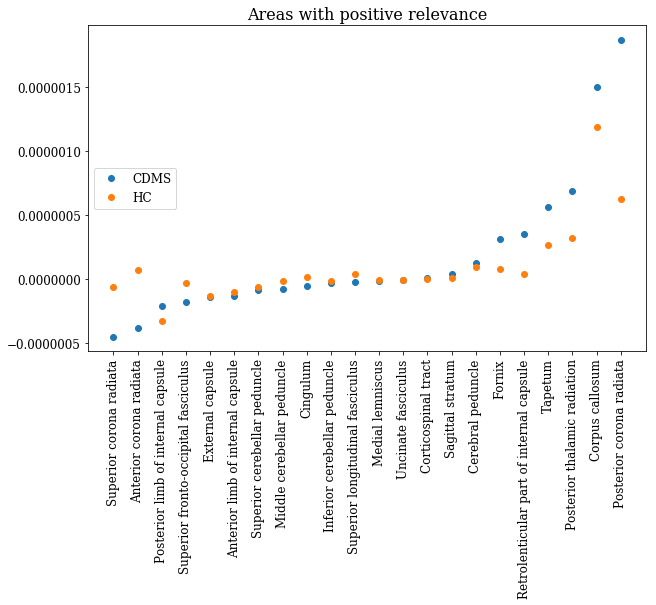

In [130]:
plot_key_value_pairs(keys, values, "Areas with positive relevance")

In [781]:
# save positive not normalized values for comparison
#with open("/analysis/ritter/projects/MS/interm_results/evidence_in_area-absolute-TP-normal_images.csv", 'w') as file:
#    wr = csv.writer(file)
#    wr.writerow(["area", "relevance"])
#    for row in zip(keys[0], values[0]):
#        wr.writerow(row)

Positive Normalized

In [132]:
norm_keys, norm_values = get_area_relevance(hms, wm_atlas, wm_areas, positive=True, size_normalize=True)

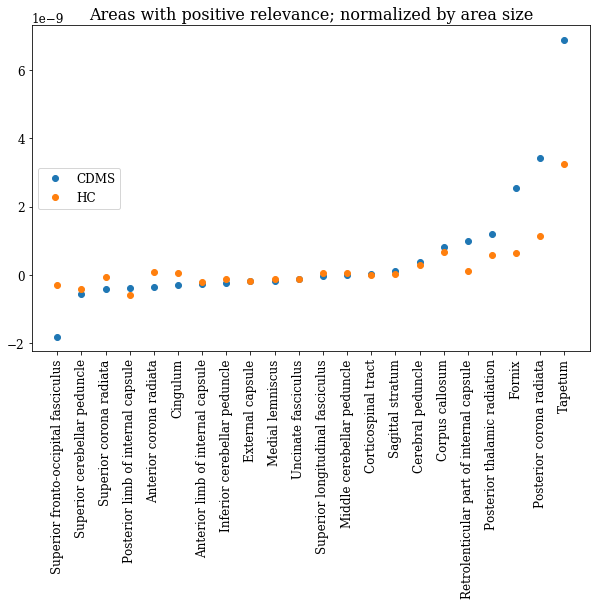

In [133]:
plot_key_value_pairs(norm_keys, norm_values, "Areas with positive relevance; normalized by area size")

In [784]:
# save positive normalized values for comparison
#with open("/analysis/ritter/projects/MS/interm_results/evidence_in_area-normalized-TP-normal_images.csv", 'w') as file:
#    wr = csv.writer(file)
#    wr.writerow(["area", "relevance"])
#    for row in zip(norm_keys[0], norm_values[0]):
#        wr.writerow(row)

### Subject wise atlas analysis

In [134]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=True)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=True)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]
            
df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


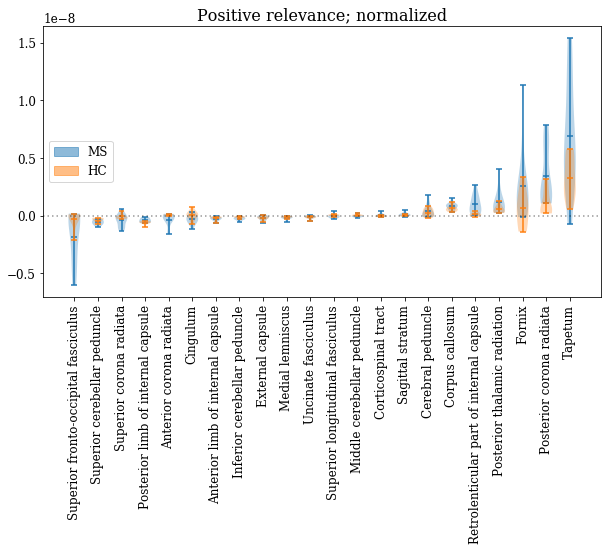

In [135]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[df_TP[key].values.astype(np.float) for key in norm_keys[0]], showmeans=True)
axes.violinplot(dataset=[df_TN[key].values.astype(np.float) for key in norm_keys[0]], showmeans=True)

axes.set_xticks(range(1, len(df_TP.columns)+1))
axes.set_xticklabels([key for key in norm_keys[0]])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")

axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Positive relevance; normalized")
file_path = os.path.join(image_file_dir, "relevance_WM_normal-scans_normalized.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
plt.show()

Not normalized

In [136]:
TP_heatmaps_holdout_list, TN_heatmaps_holdout_list = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction', as_list=True)

keys_TP, values_TP = get_area_relevance(TP_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=False)
keys_TN, values_TN = get_area_relevance(TN_heatmaps_holdout_list, wm_atlas, wm_areas, positive=True, size_normalize=False)

hm_distrib_TP = {}
for key, ind_value in zip(keys_TP, values_TP):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TP.keys():
            hm_distrib_TP[area].append(value)
        else:
            hm_distrib_TP[area] = [value,]

hm_distrib_TN = {}
for key, ind_value in zip(keys_TN, values_TN):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_TN.keys():
            hm_distrib_TN[area].append(value)
        else:
            hm_distrib_TN[area] = [value,]

df_TP = pd.DataFrame(hm_distrib_TP)
df_TN = pd.DataFrame(hm_distrib_TN)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


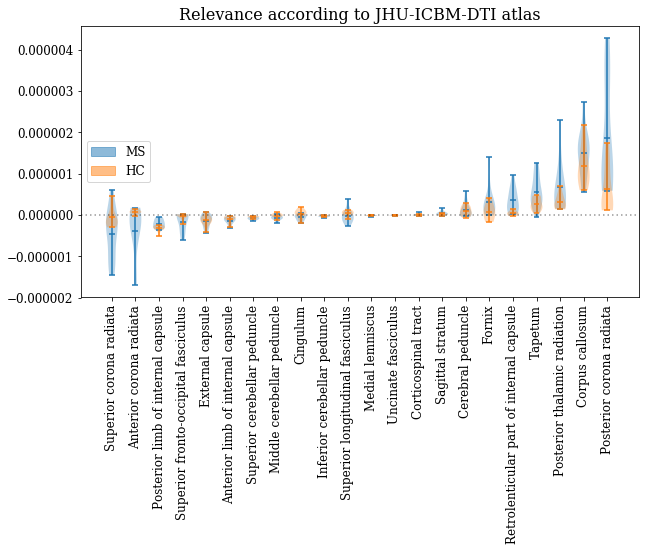

In [138]:
#plt.figure()
fig, axes = plt.subplots(figsize=(10, 5))
axes.violinplot(dataset=[df_TP[key].values.astype(np.float) for key in keys[0]], showmeans=True)
axes.violinplot(dataset=[df_TN[key].values.astype(np.float) for key in keys[0]], showmeans=True)

axes.set_xticks(range(1, len(df_TP.columns)+1))
axes.set_xticklabels([key for key in keys[0]])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")

axes.axhline(y=0, color='black', alpha=0.4, dashes=(1, 2))
plt.title("Relevance according to JHU-ICBM-DTI atlas")
file_path = os.path.join(image_file_dir, "relevance_WM_normal-scans_absolute.png")
#plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')

plt.show()

# Training averages

### MS vs HC

2.4778343122768636


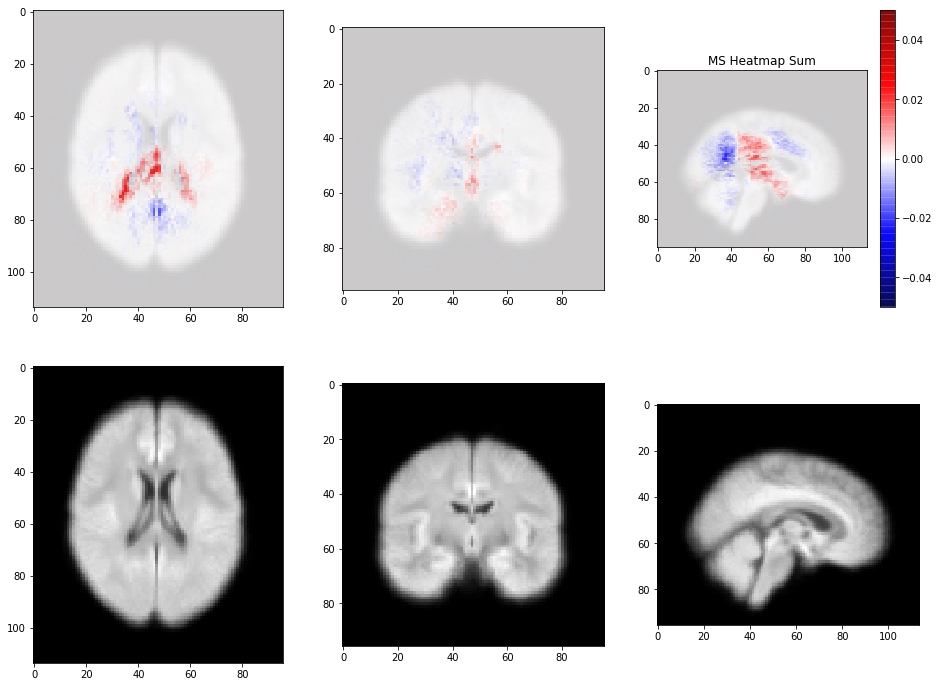

-1.7296983448481573


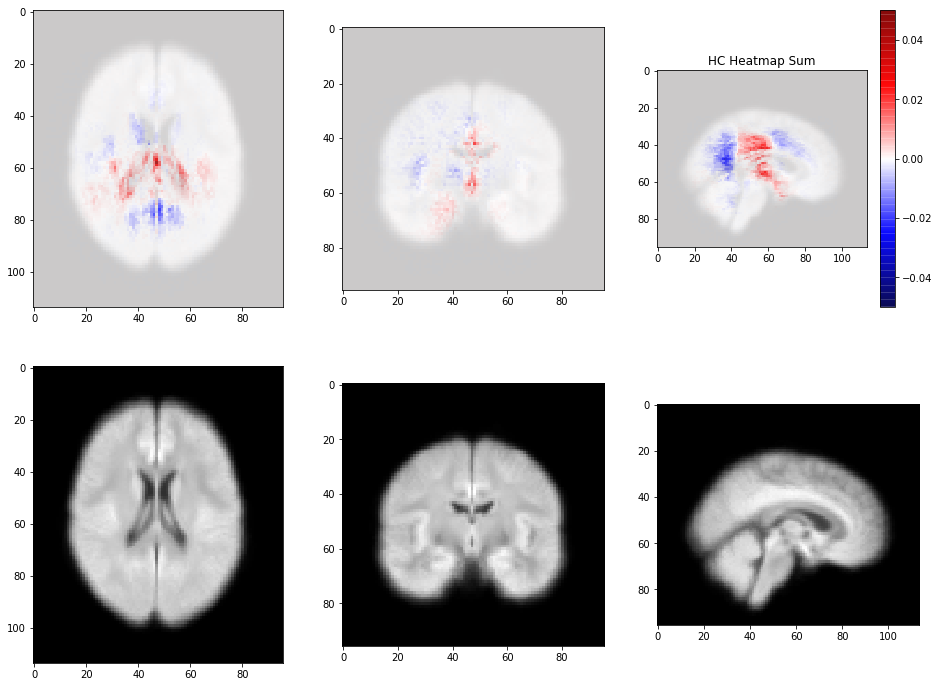

In [852]:
hms = [ms_heatmaps_train, hc_heatmaps_train]
titles = ["MS Heatmap Sum", "HC Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

### TP vs TN

2.8695573855168734


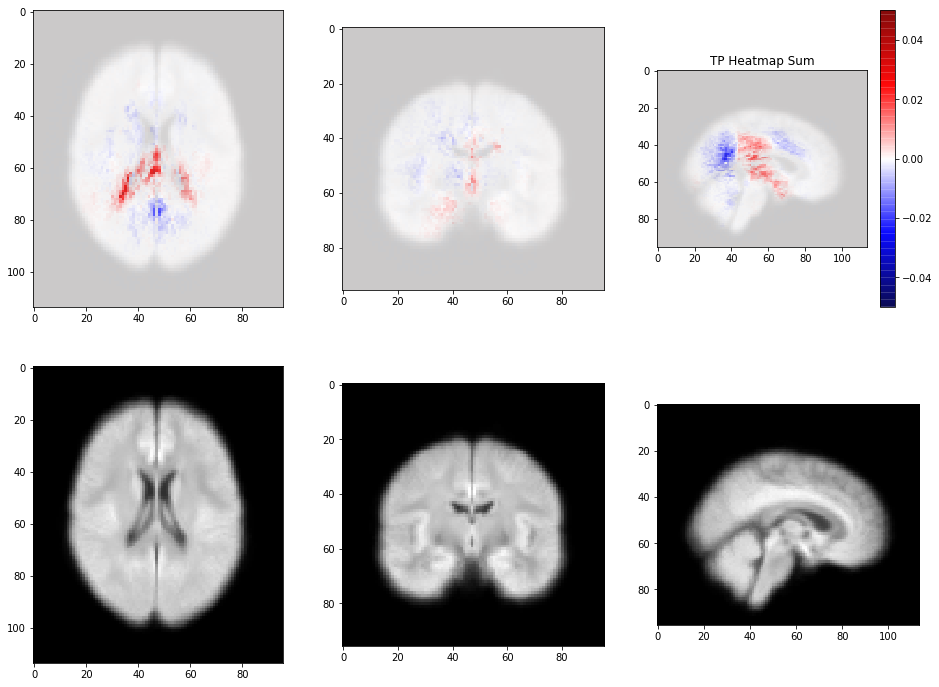

-1.7296984606285826


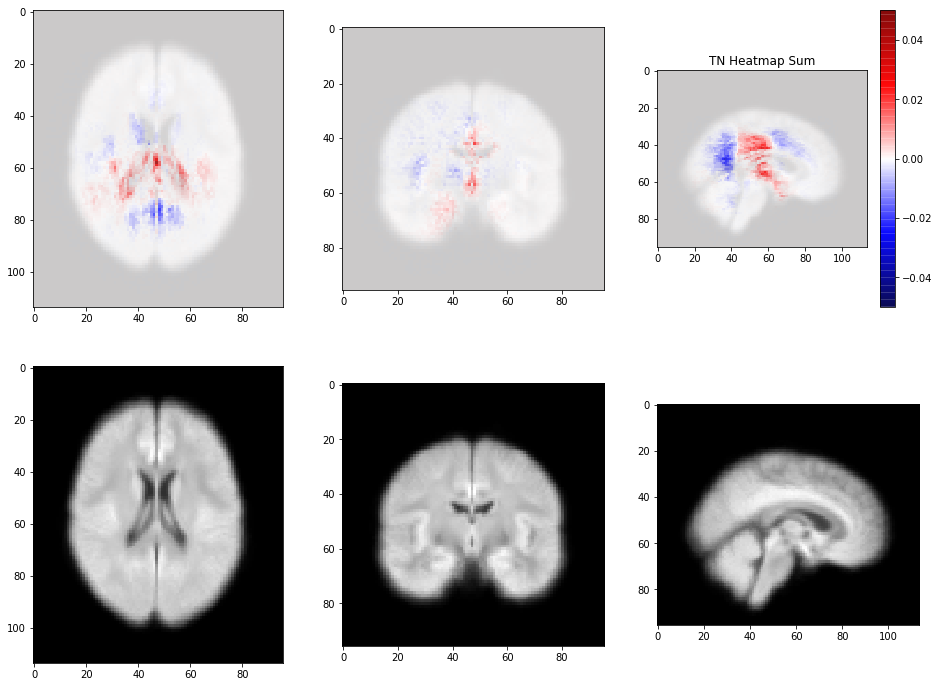

In [853]:
hms = [TP_heatmaps_train, TN_heatmaps_train]
titles = ["TP Heatmap Sum", "TN Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

In [710]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

2.4363267745976214
-1.8552411610413297


In [689]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

1.966618770852537
-1.8151282016099968


### Gradient based

In [206]:
ms_heatmaps = np.zeros_like(analysis)
hc_heatmaps = np.zeros_like(analysis)
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    # Normalize heatmaps
    analysis = (analysis - np.min(analysis))/(np.max(analysis) - np.min(analysis))
    # Sorting by label
    if label == 1:
        ms_heatmaps += analysis
    else:
        hc_heatmaps += analysis

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [207]:
# Average values over number of samples
ms_heatmaps /= len(test_loader)
hc_heatmaps /= len(test_loader)

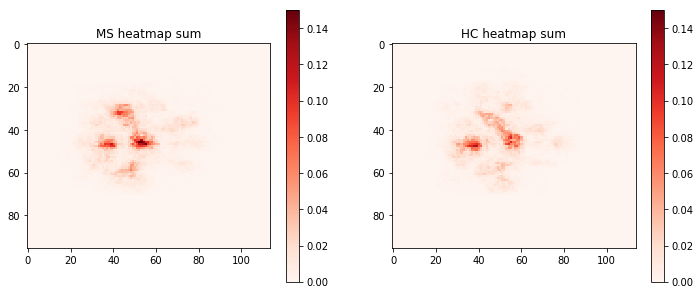

In [208]:
plt.figure(figsize=(12, 5))
vmin = np.min(np.squeeze(ms_heatmaps)[:,:,sl])
vmax = np.max(np.squeeze(ms_heatmaps)[:,:,sl])
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(ms_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("MS heatmap sum")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(hc_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("HC heatmap sum")
plt.colorbar()
plt.show()

In [817]:
def replace_activations(model, activation=keras.activations.relu):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Conv3D):
            layer.activation = activation
    return model

In [818]:
#model = replace_activations(model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

#beheaded_model = replace_activations(beheaded_model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#beheaded_model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

# Visualizing 4 subjects

### MS

In [2283]:
# find subjects with highest sigmoid output
scores = []
for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    score = fine_tuned_model.predict(image)
    scores.append(score[0][0])
idx_list = np.argsort(-np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


#########
Index 6
Score 0.996423
#########
Index 4
Score 0.980106
#########
Index 8
Score 0.973384
#########
Index 12
Score 0.970622
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [1.] 
sigmoid score [0.99642295]
beheaded score 5.629638
analysis sum 6.679100


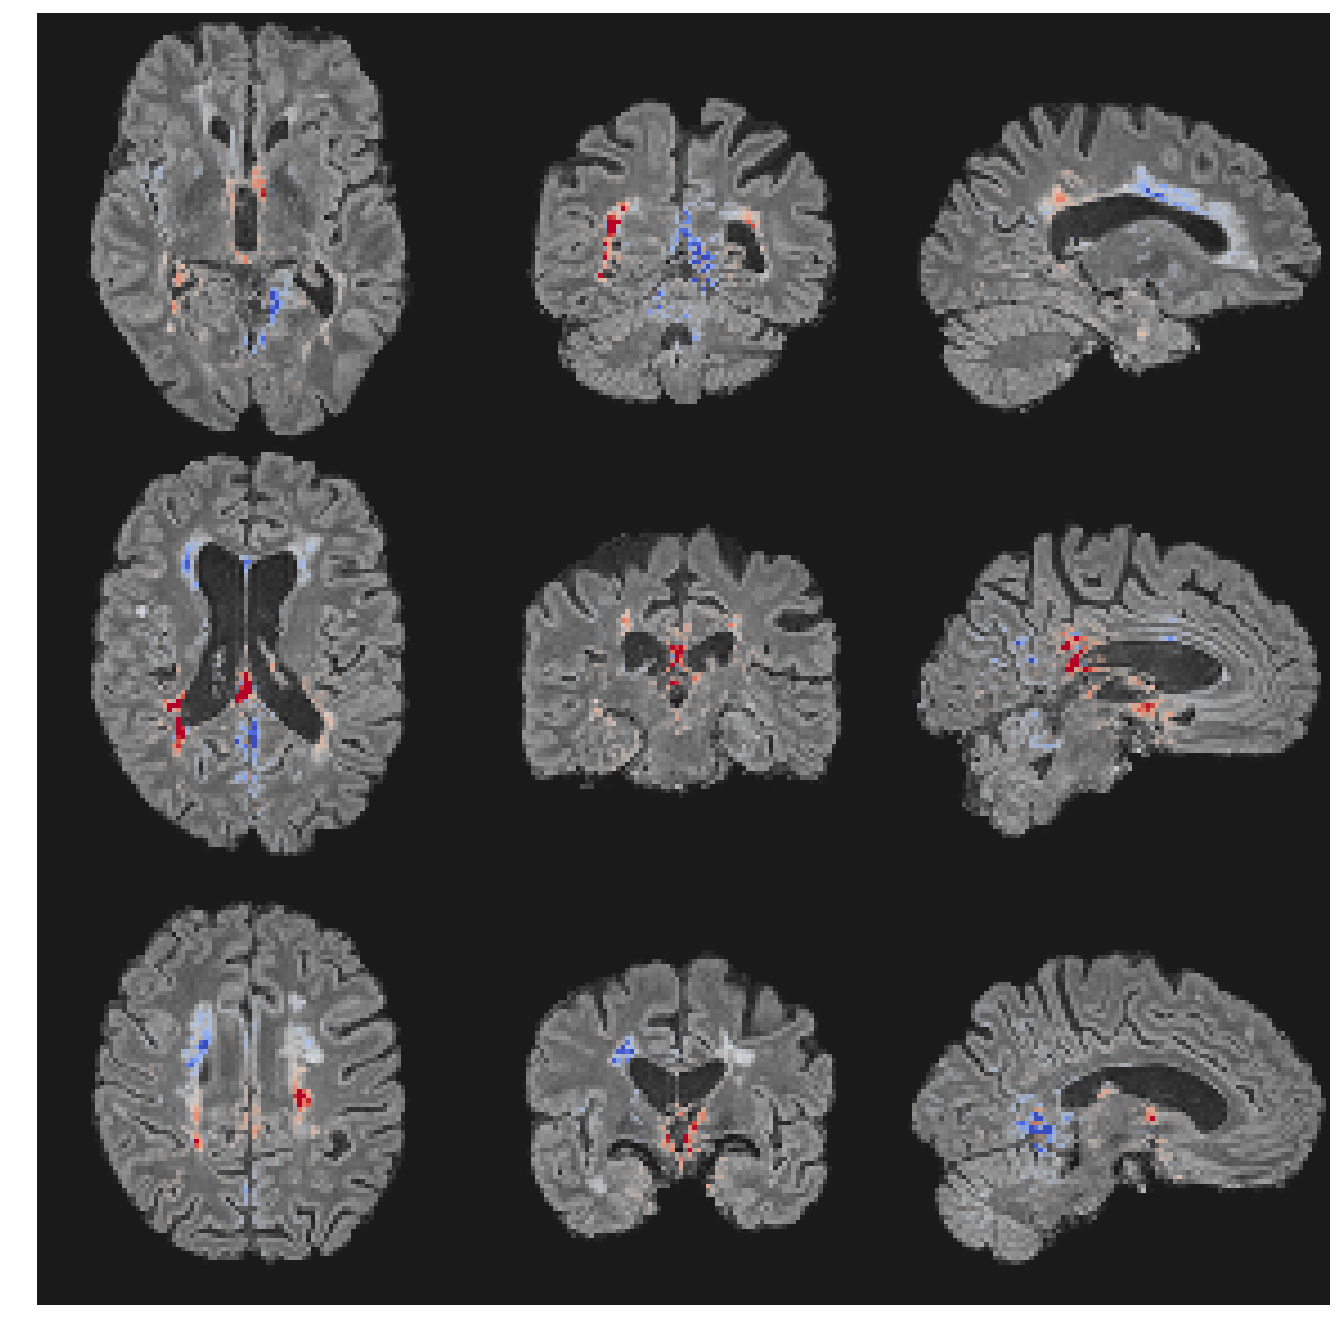

pred [1.] 
sigmoid score [0.9801063]
beheaded score 3.897254
analysis sum 5.314578


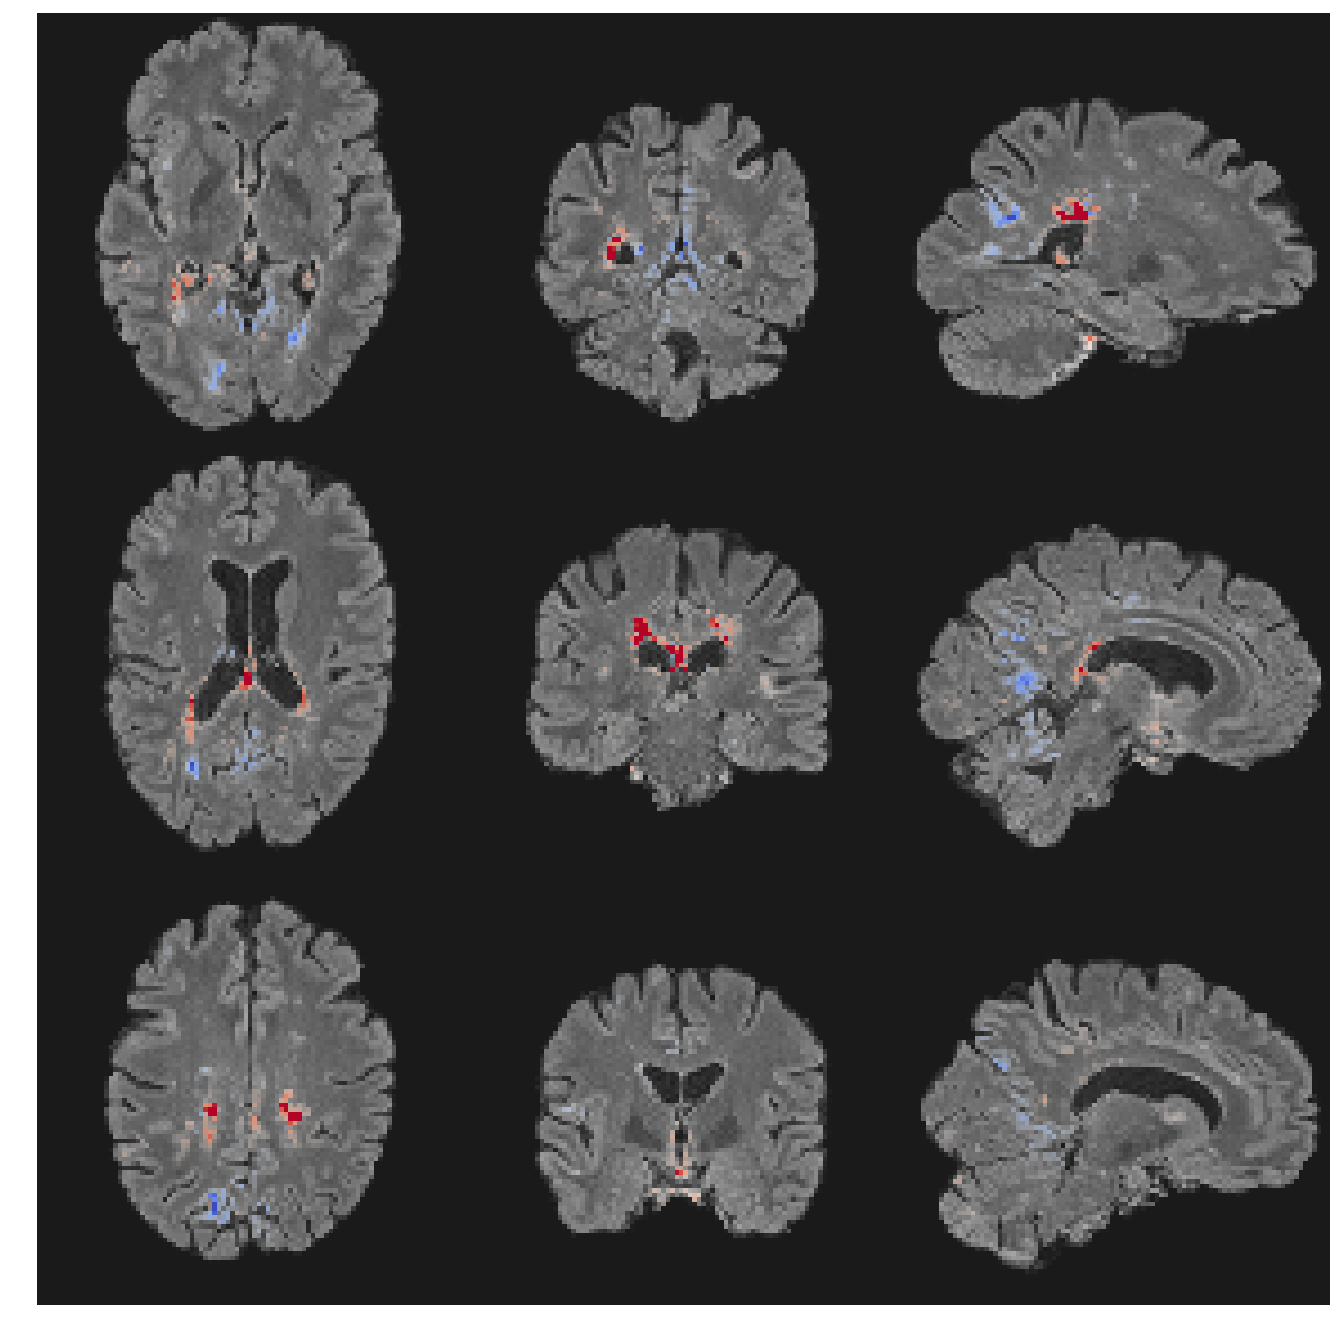

pred [1.] 
sigmoid score [0.97338426]
beheaded score 3.599277
analysis sum 4.413382


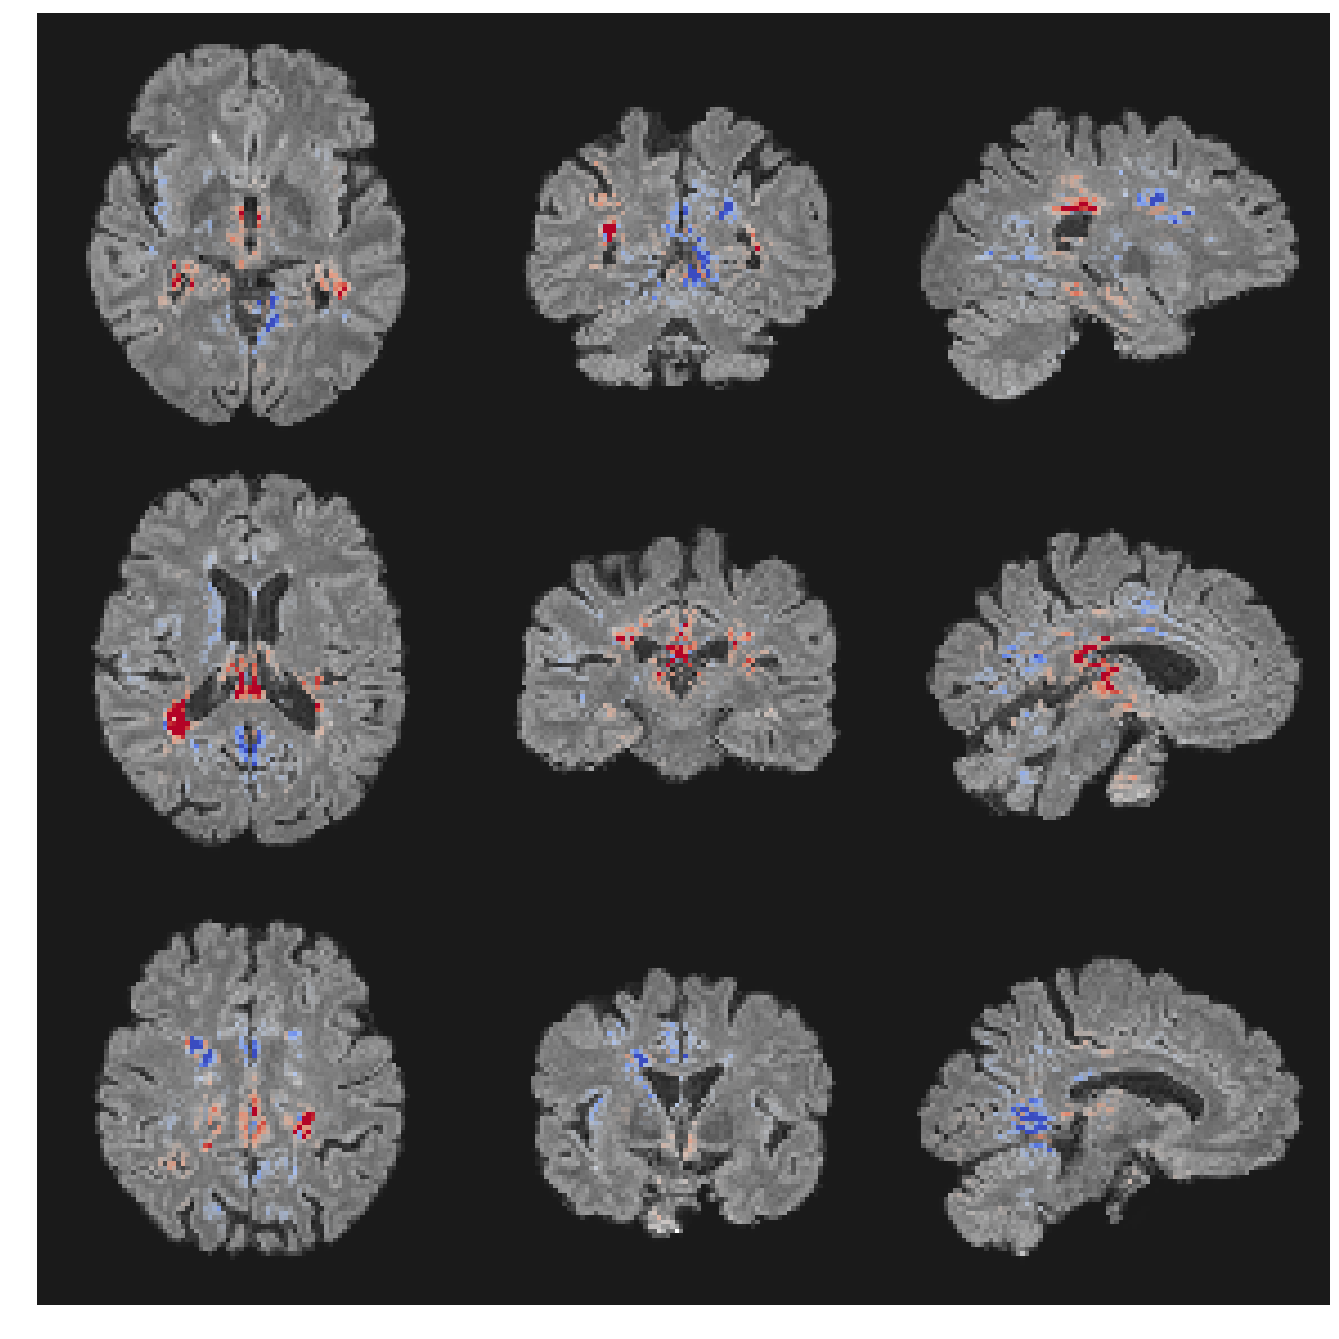

pred [1.] 
sigmoid score [0.9706222]
beheaded score 3.497698
analysis sum 5.073507


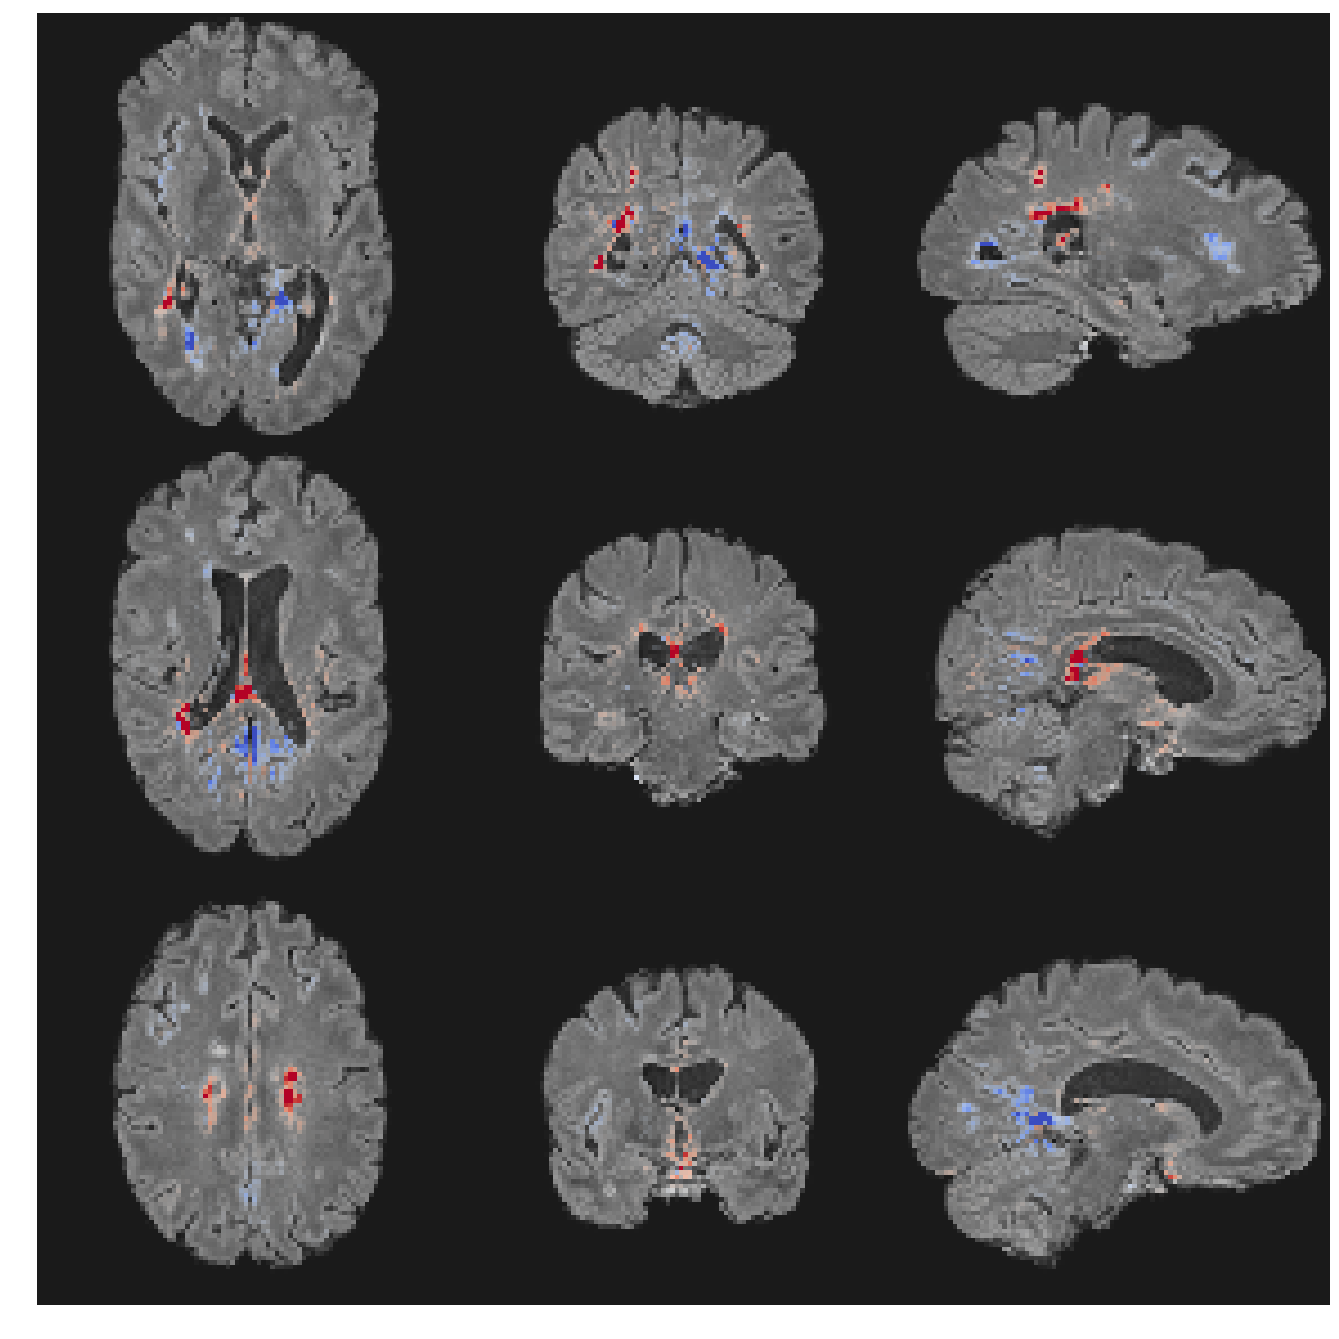

In [2284]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "MS_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

### Healthy controls

In [2321]:
# get the lowest scores i.e. best classification for HC
idx_list = np.argsort(np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

#########
Index 19
Score 0.098773
#########
Index 3
Score 0.229042
#########
Index 20
Score 0.273408
#########
Index 17
Score 0.276104
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [0.] 
sigmoid score [0.09877317]
beheaded score -2.210931
analysis sum -2.669526


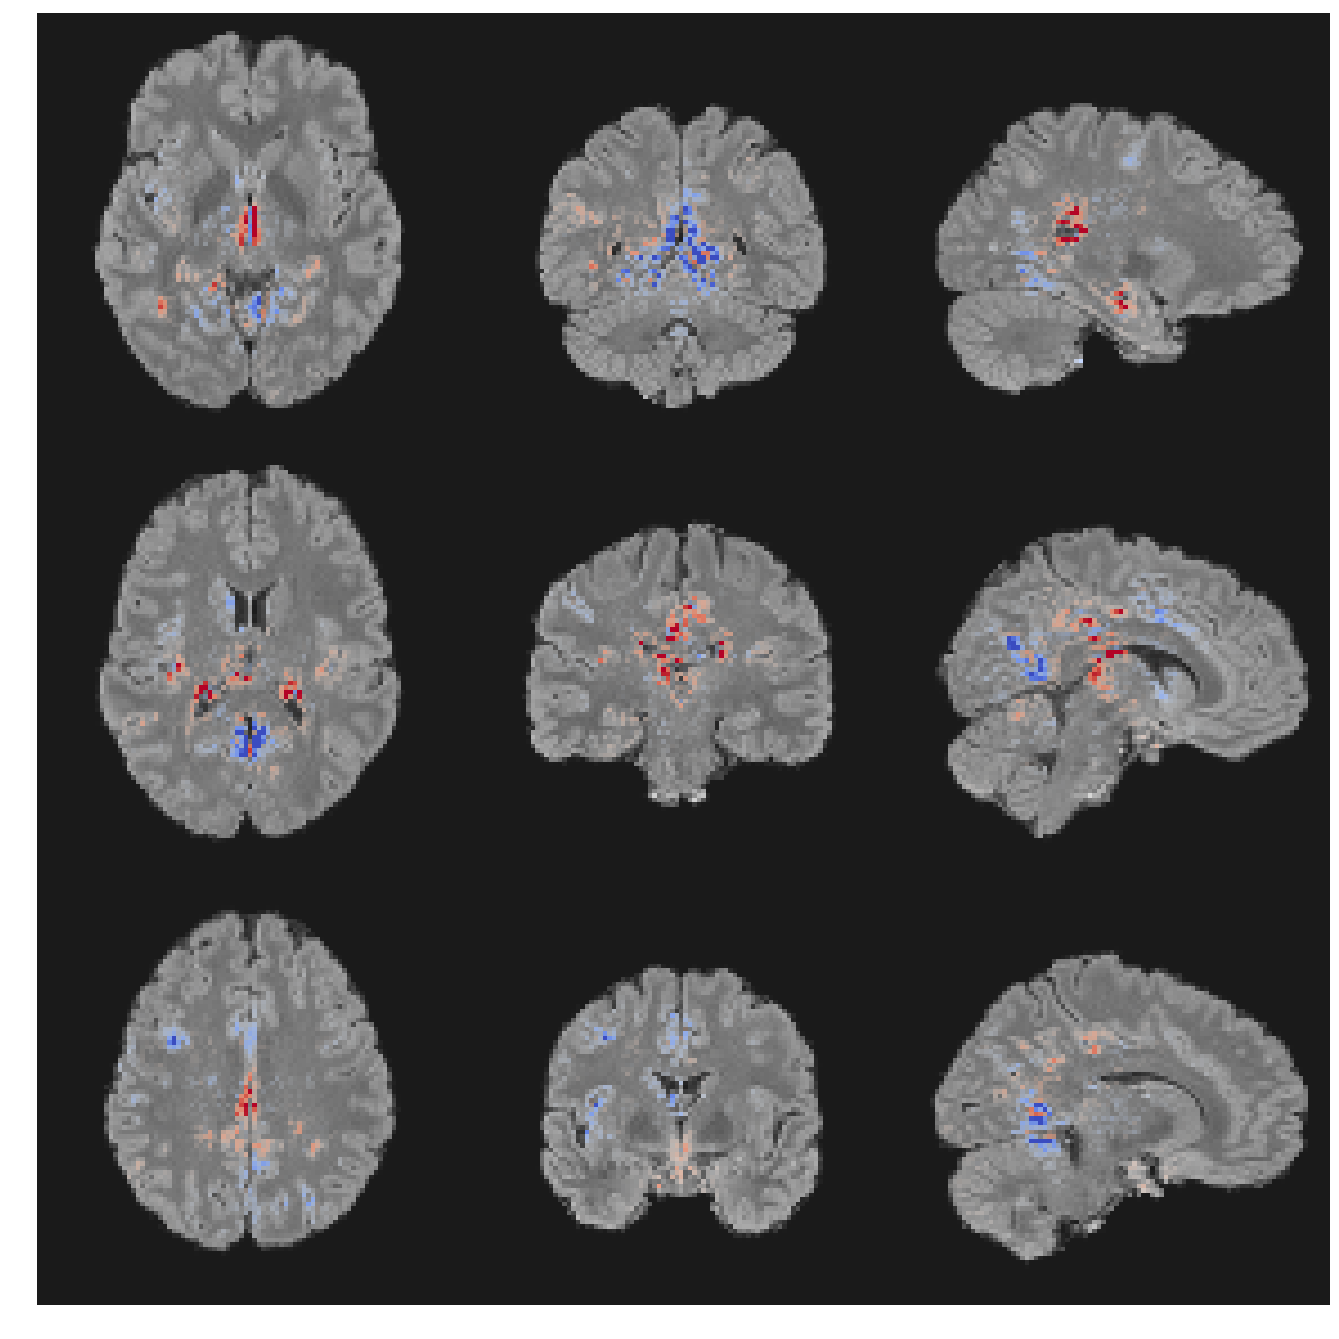

pred [0.] 
sigmoid score [0.2290421]
beheaded score -1.213728
analysis sum -1.658456


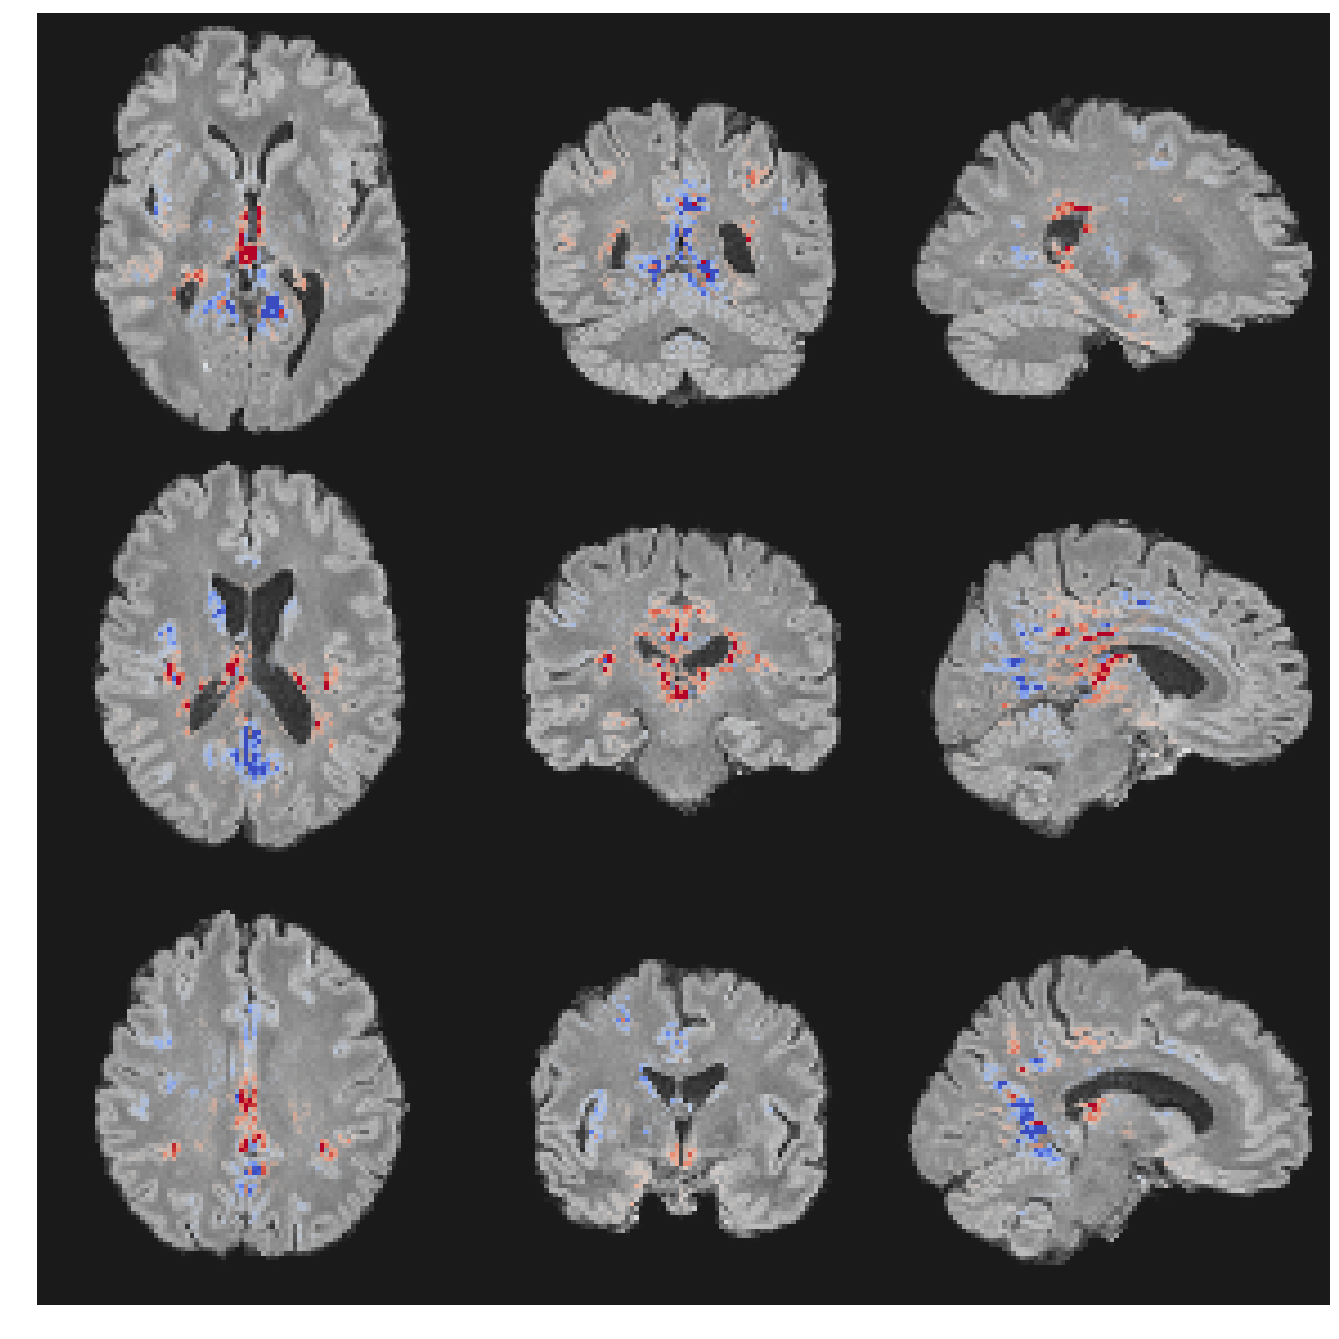

pred [0.] 
sigmoid score [0.27340817]
beheaded score -0.977399
analysis sum -1.177916


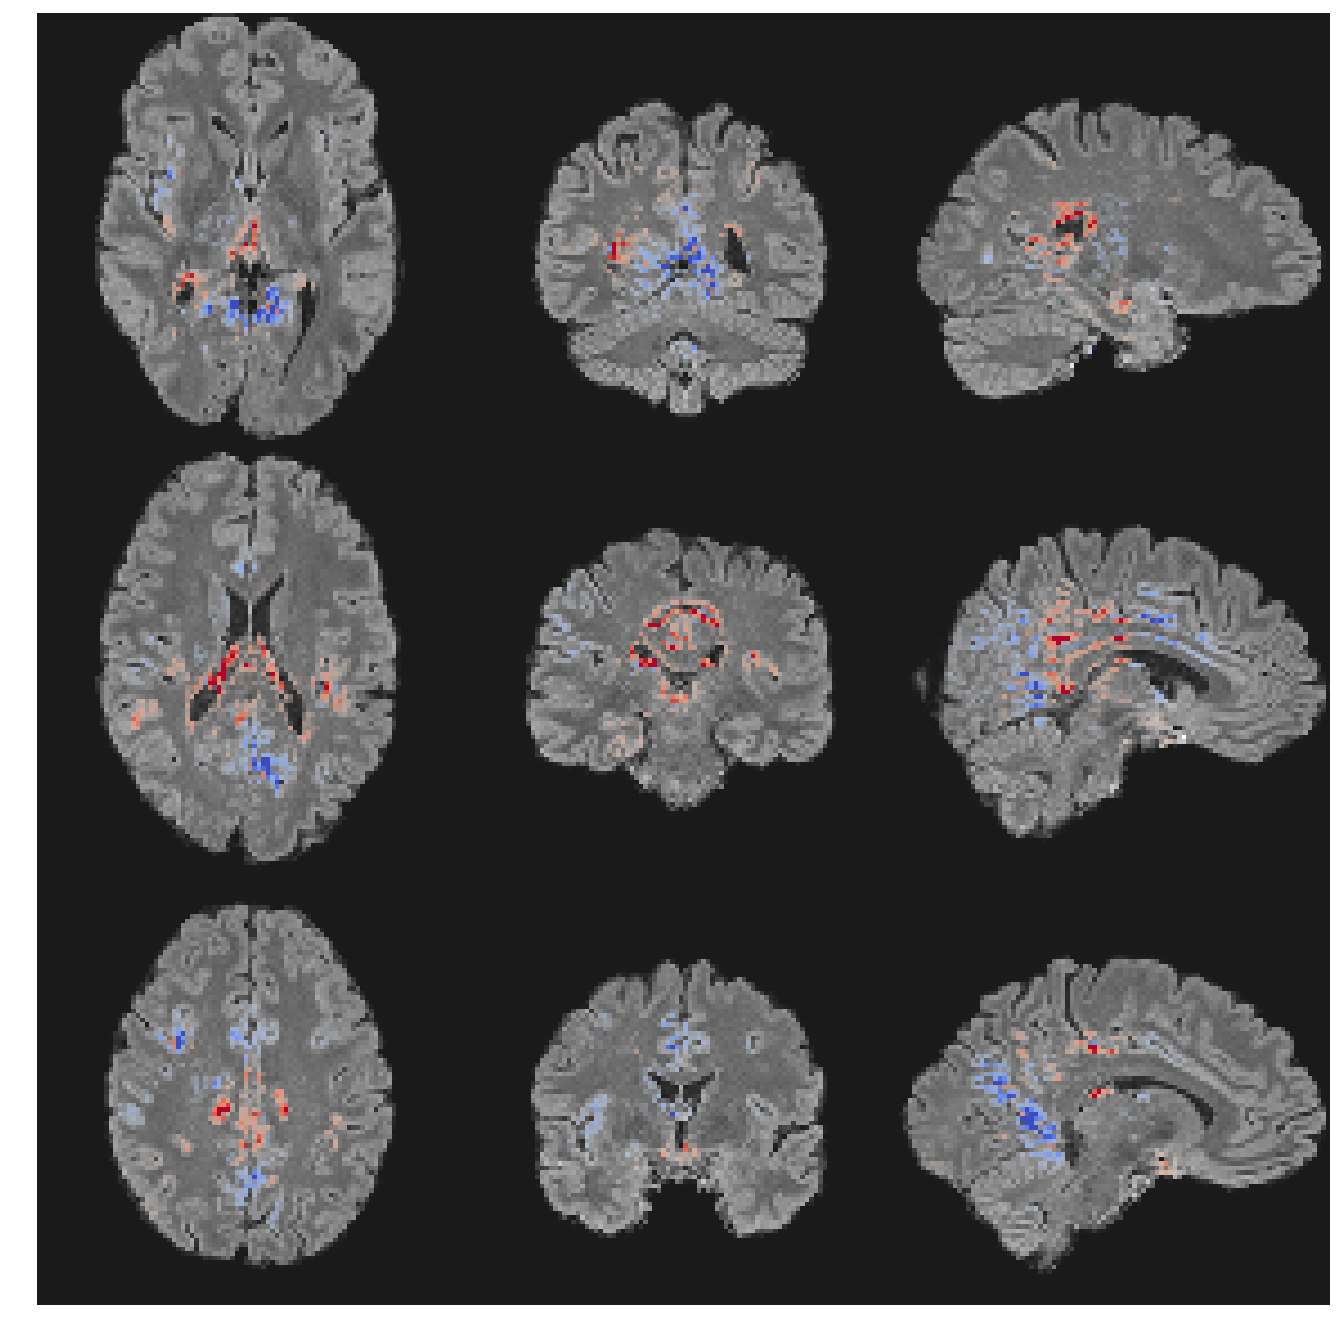

pred [0.] 
sigmoid score [0.27610388]
beheaded score -0.963871
analysis sum -1.569889


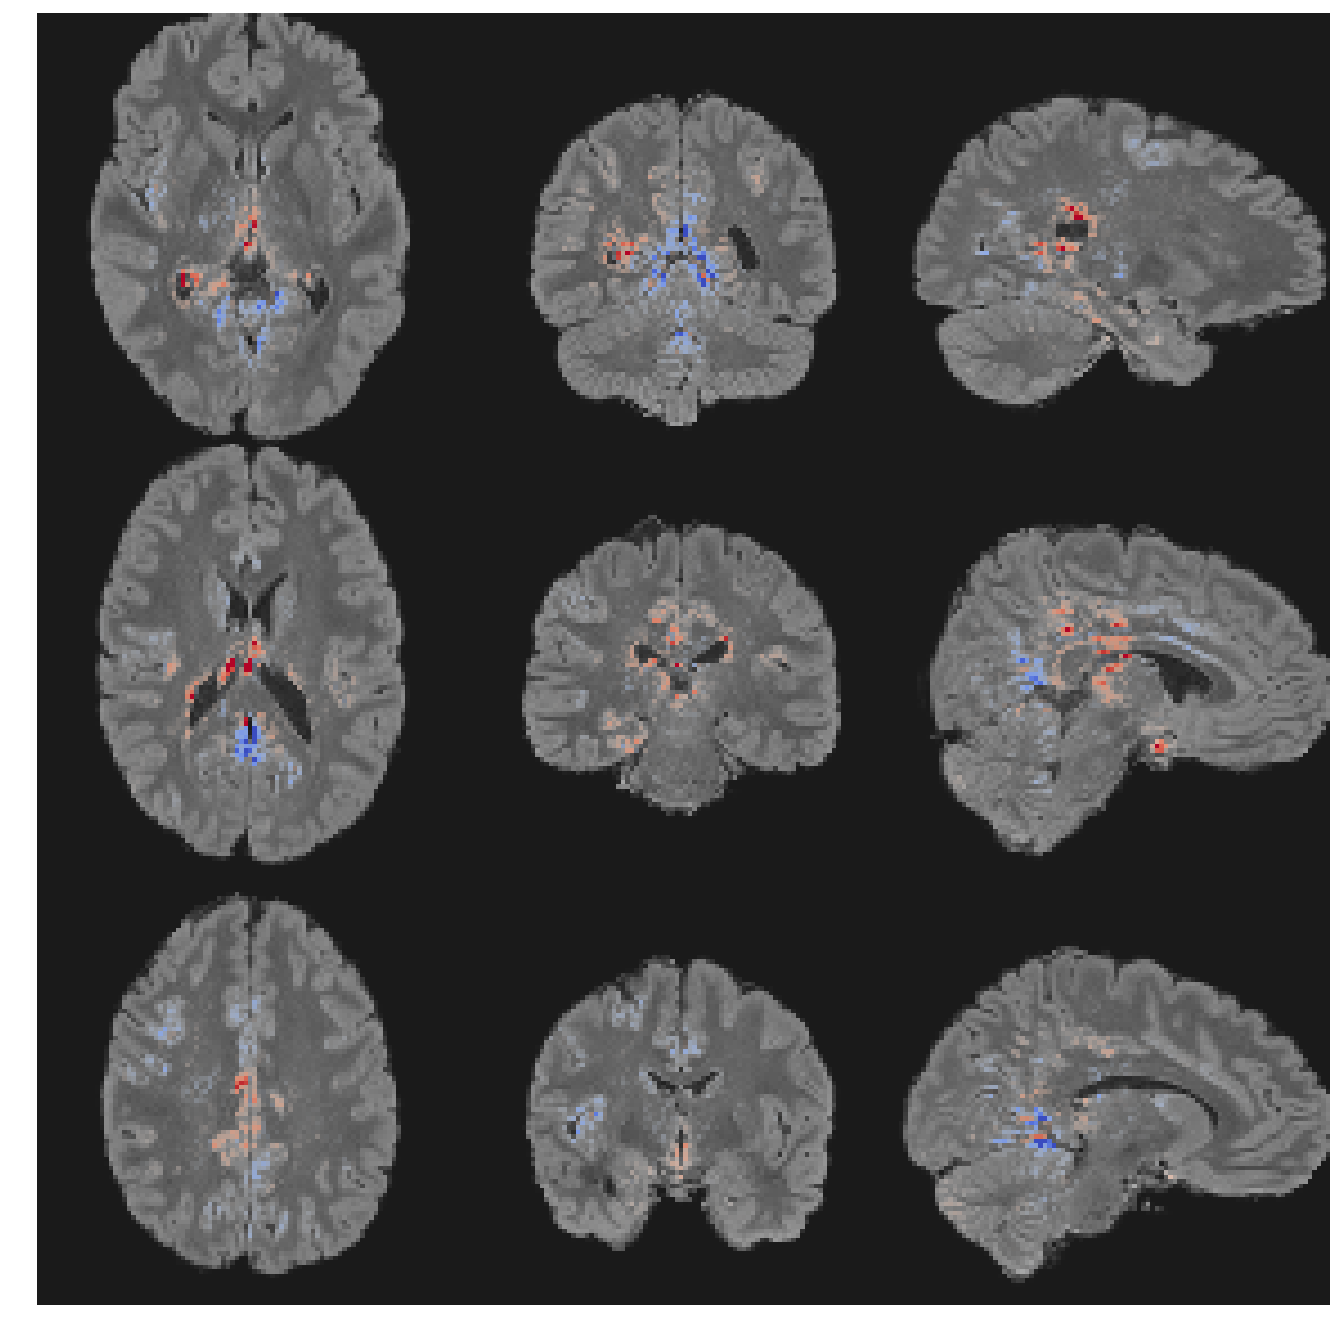

In [2322]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "HC_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

# Visualizing all holdout scans

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [1.] 
sigmoid score [0.5888045]
beheaded score 0.359025
analysis sum 0.920706


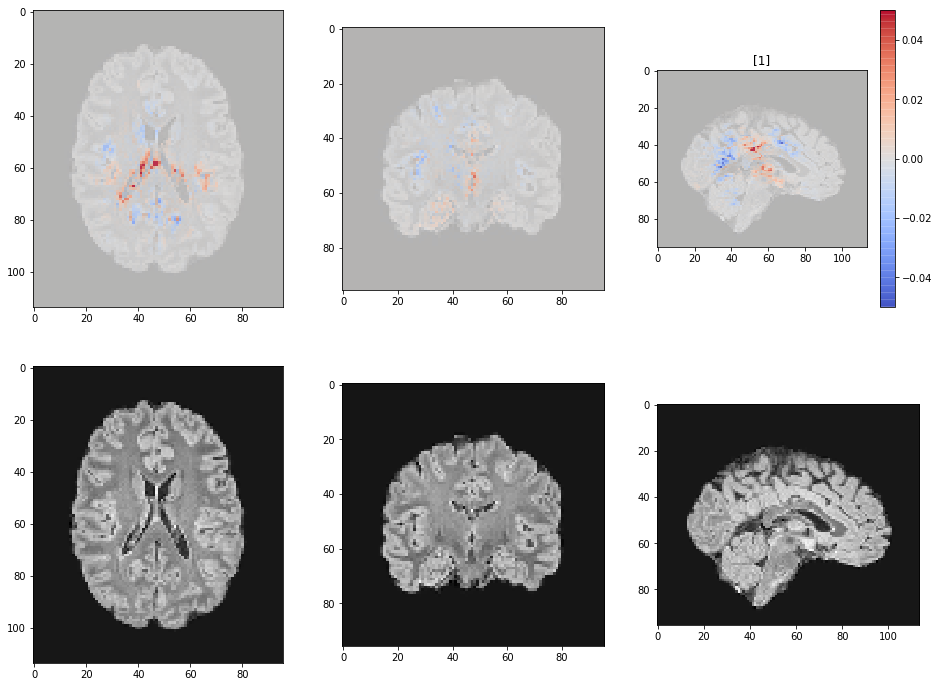

pred [1.] 
sigmoid score [0.63422424]
beheaded score 0.550382
analysis sum 0.639513


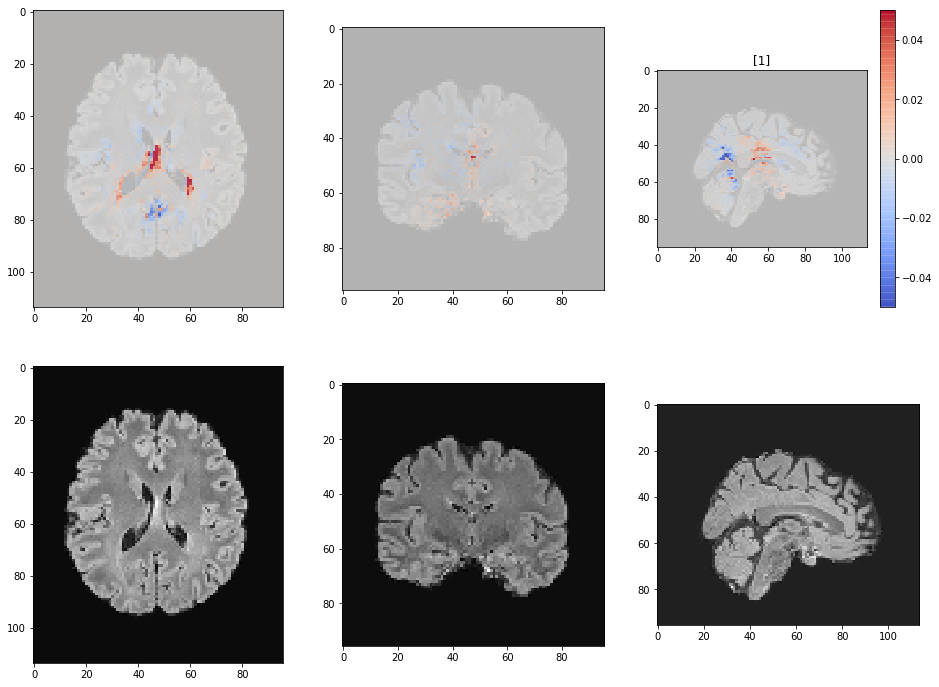

pred [0.] 
sigmoid score [0.3602204]
beheaded score -0.574408
analysis sum -0.527786


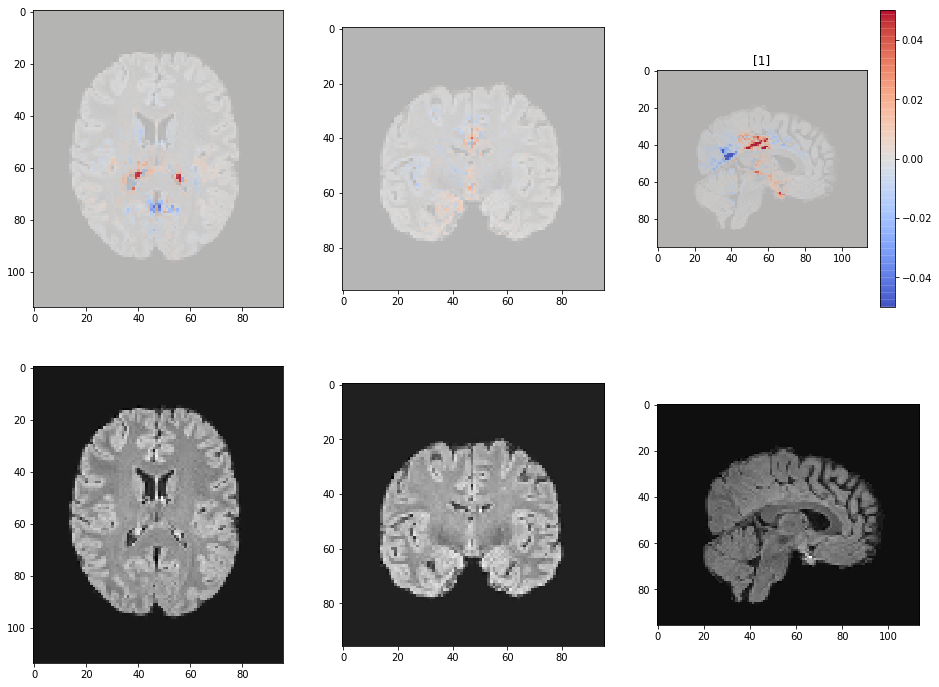

pred [0.] 
sigmoid score [0.2290421]
beheaded score -1.213728
analysis sum -1.658455


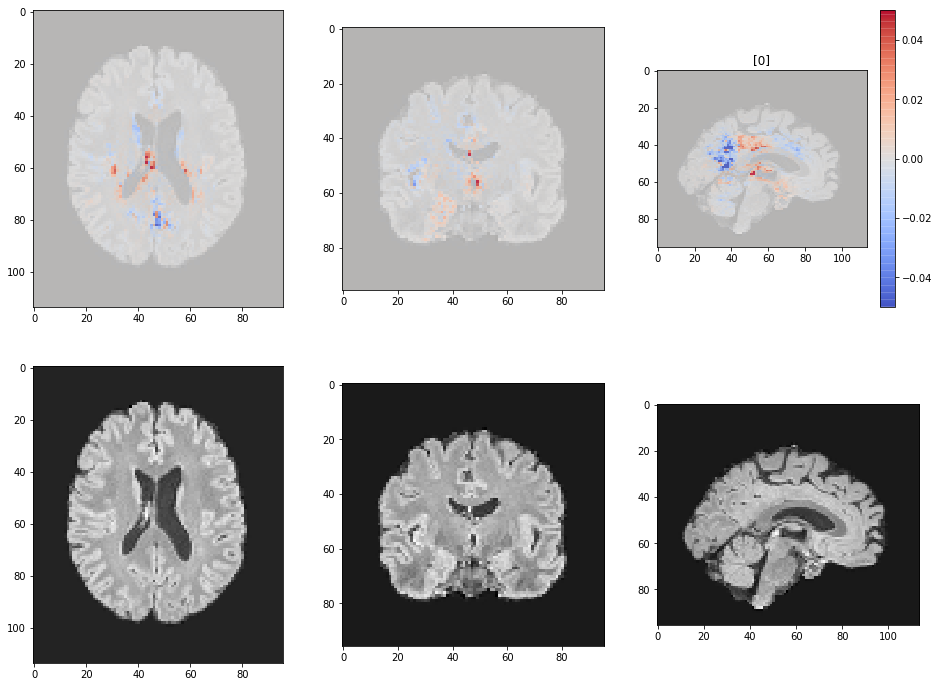

pred [1.] 
sigmoid score [0.9801063]
beheaded score 3.897254
analysis sum 5.314578


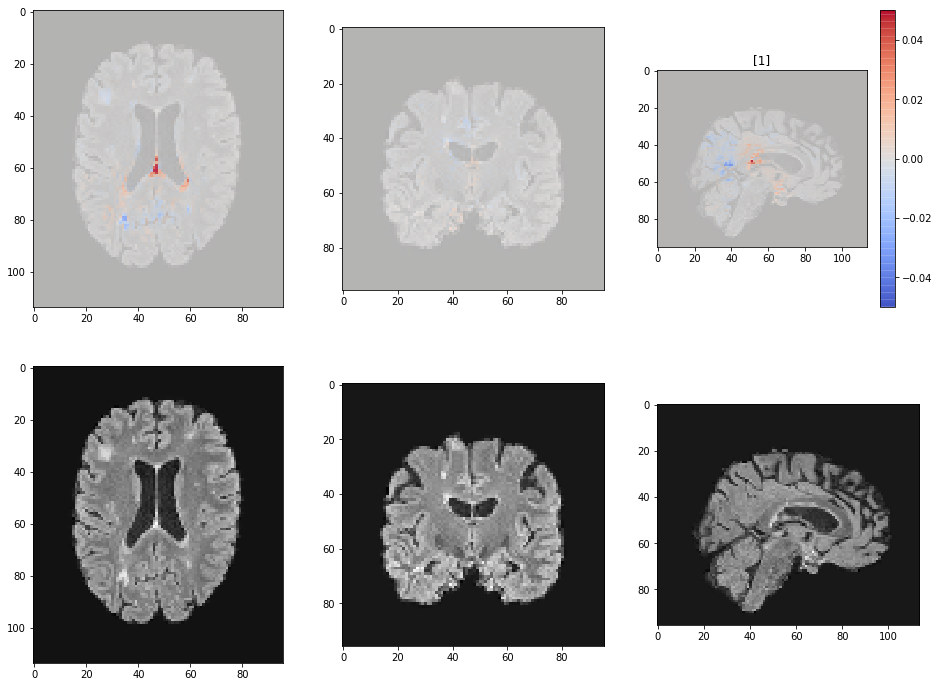

pred [0.] 
sigmoid score [0.28947553]
beheaded score -0.897933
analysis sum -0.841029


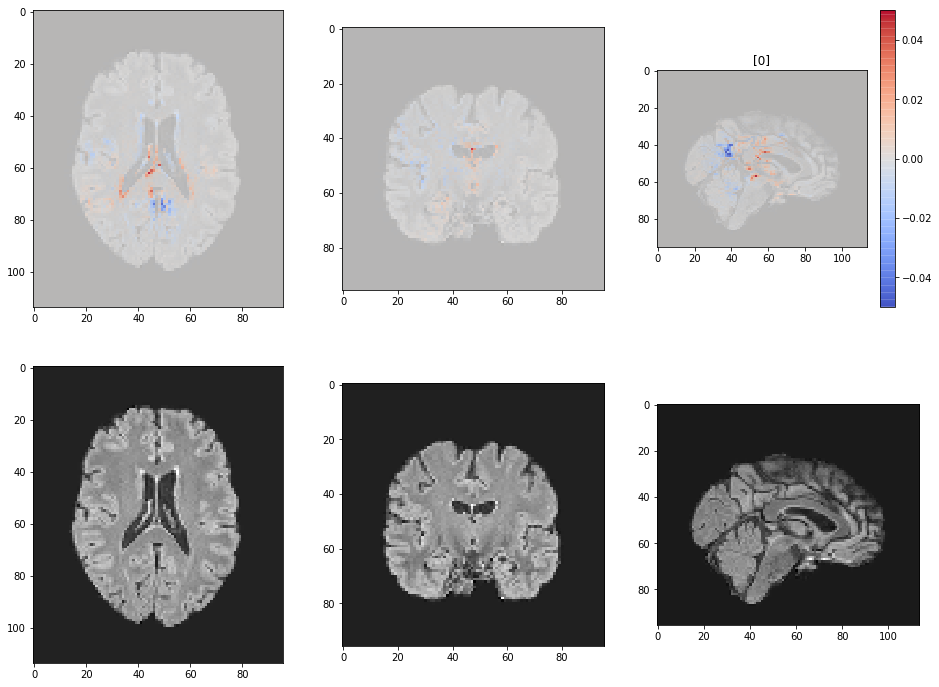

pred [1.] 
sigmoid score [0.99642295]
beheaded score 5.629638
analysis sum 6.679100


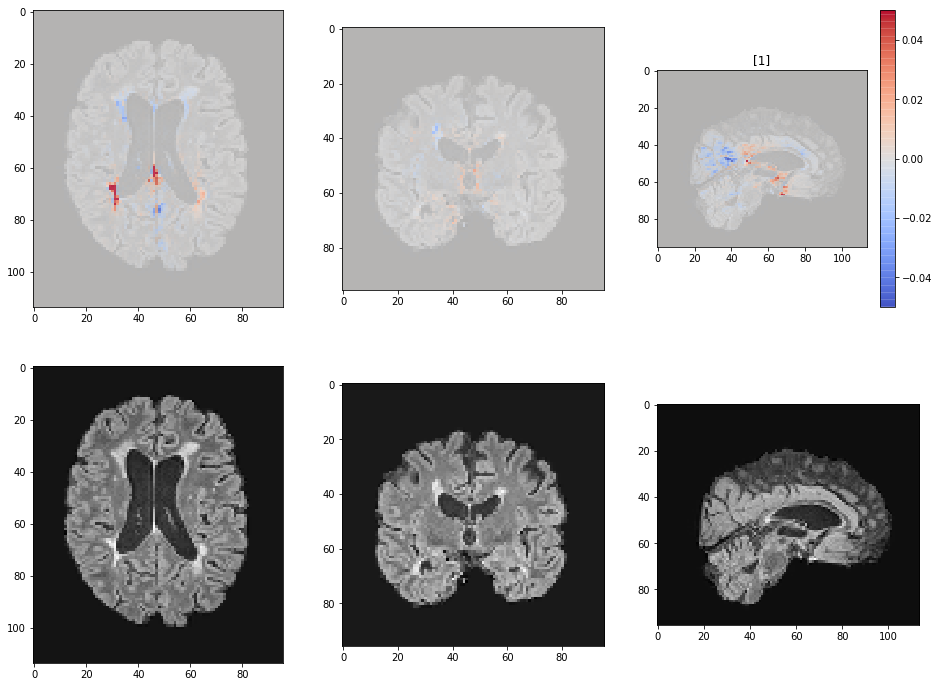

pred [0.] 
sigmoid score [0.34410045]
beheaded score -0.645074
analysis sum -0.814157


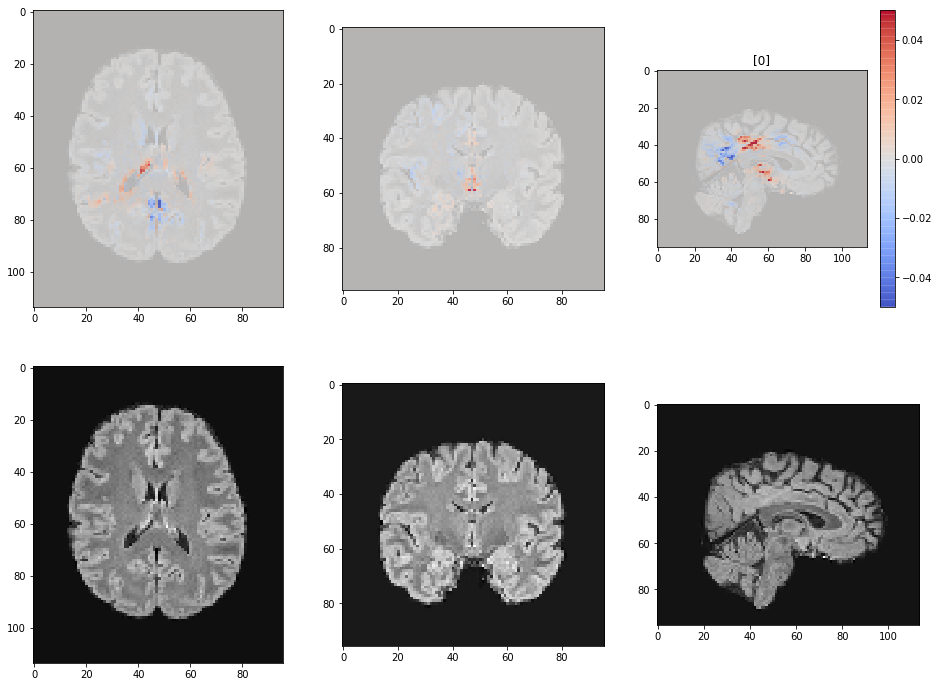

pred [1.] 
sigmoid score [0.97338426]
beheaded score 3.599277
analysis sum 4.413381


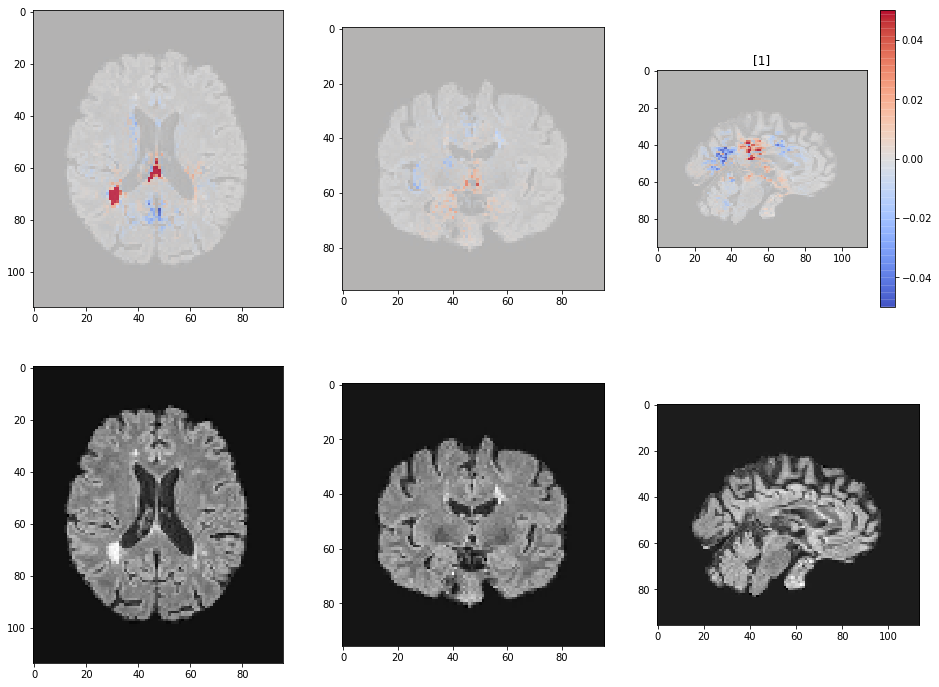

pred [1.] 
sigmoid score [0.8503438]
beheaded score 1.737301
analysis sum 2.124649


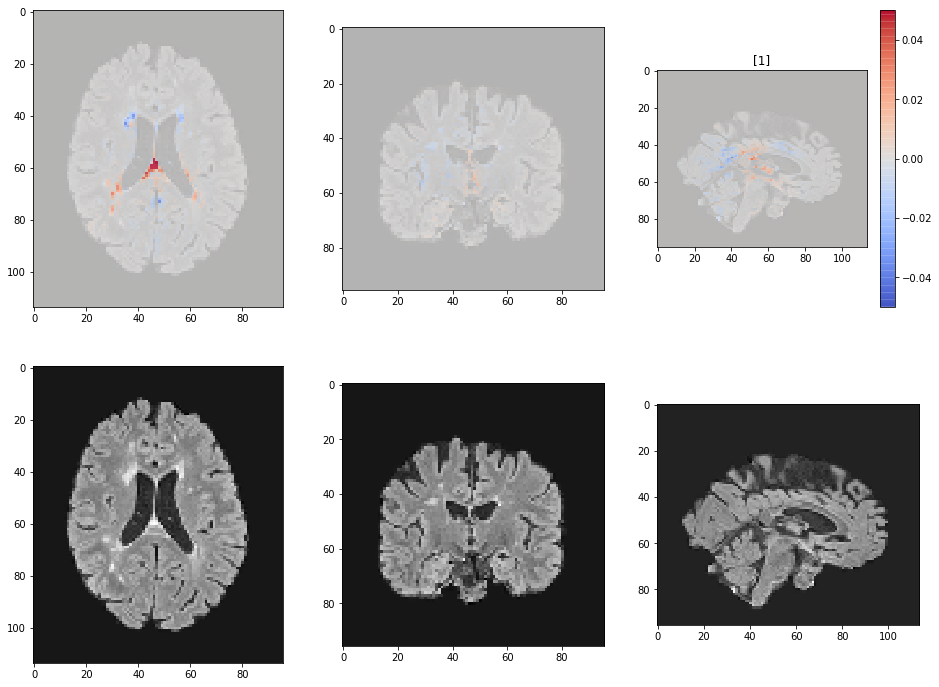

pred [0.] 
sigmoid score [0.39456418]
beheaded score -0.428167
analysis sum -0.713912


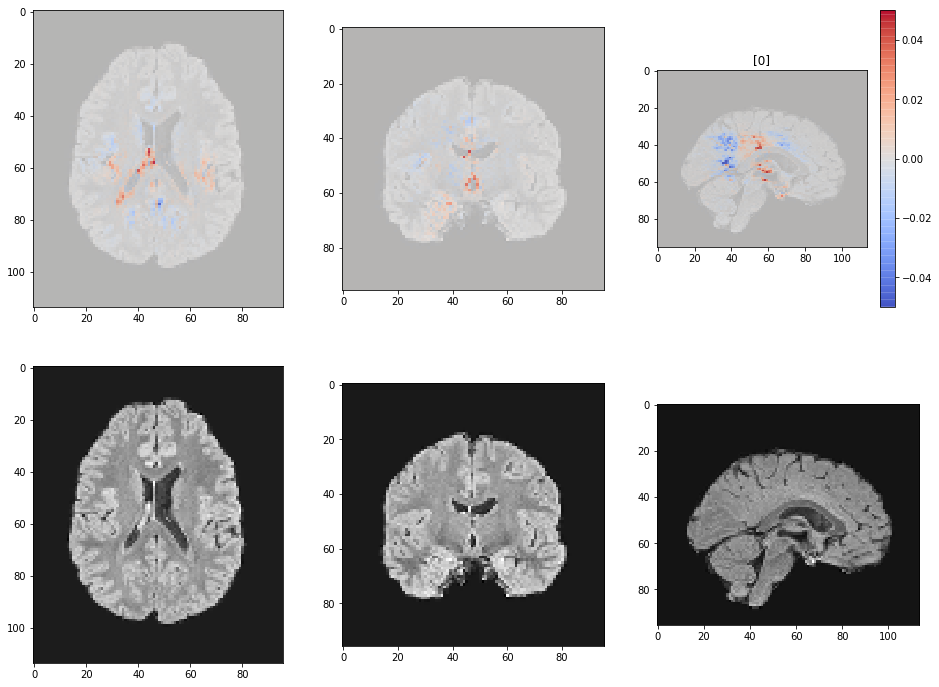

pred [1.] 
sigmoid score [0.8818087]
beheaded score 2.009670
analysis sum 2.830434


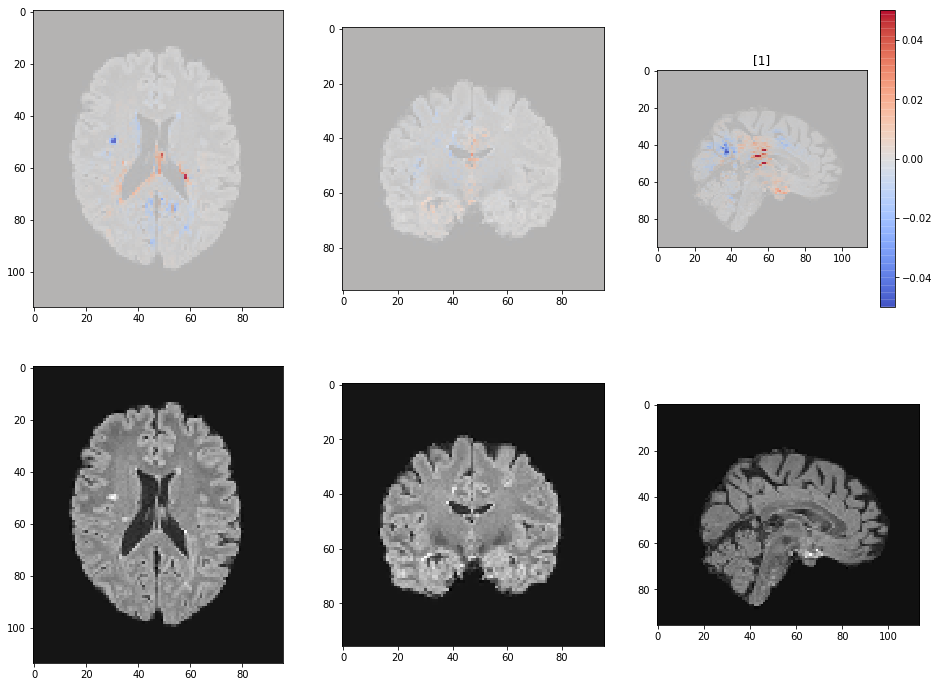

pred [1.] 
sigmoid score [0.9706222]
beheaded score 3.497698
analysis sum 5.073507


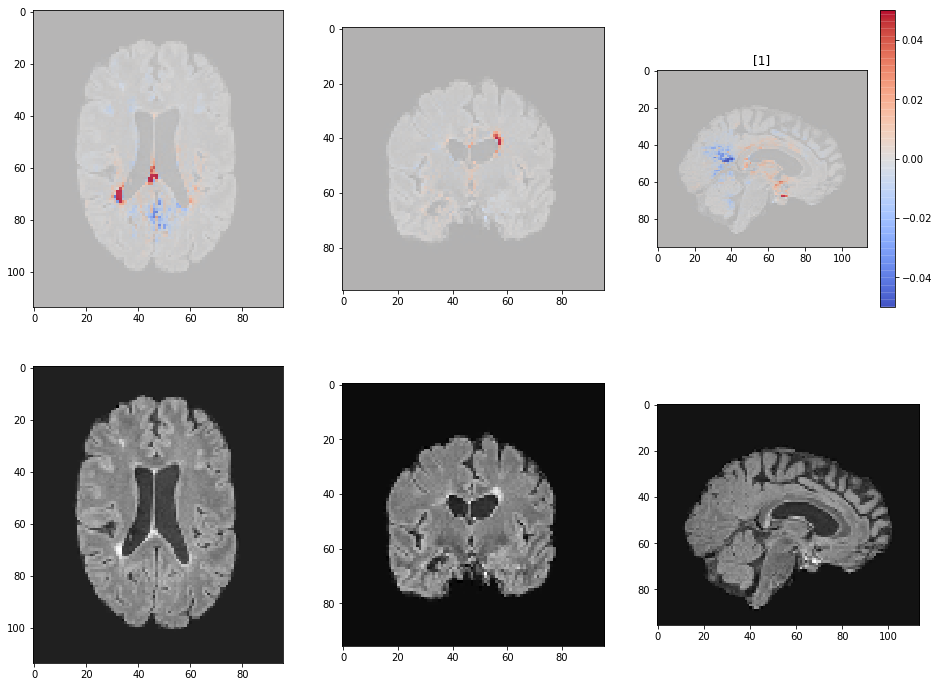

pred [1.] 
sigmoid score [0.728988]
beheaded score 0.989494
analysis sum 1.226548


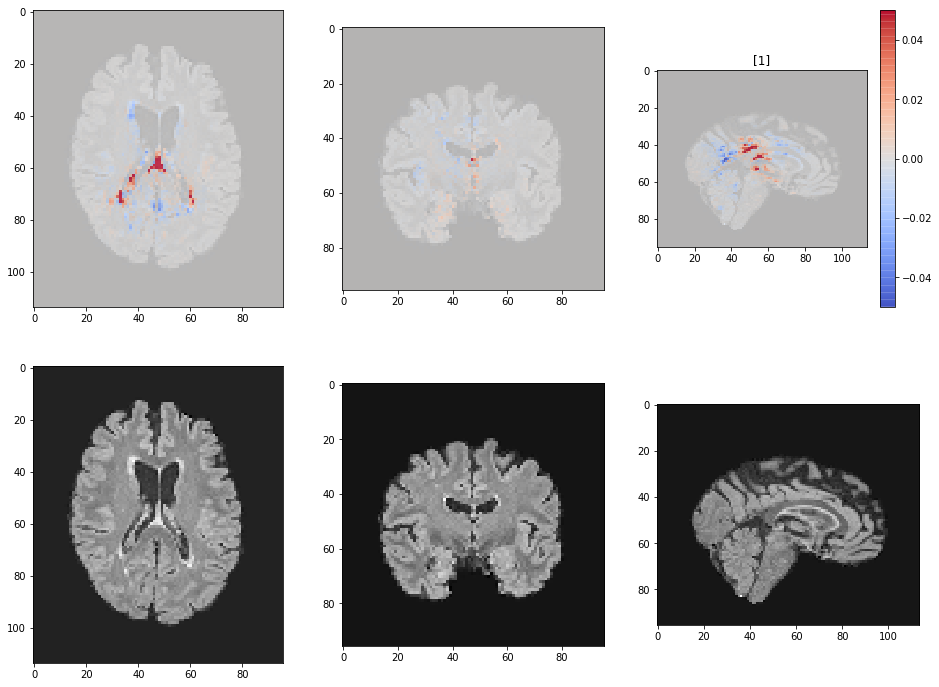

pred [1.] 
sigmoid score [0.9030025]
beheaded score 2.231040
analysis sum 3.009446


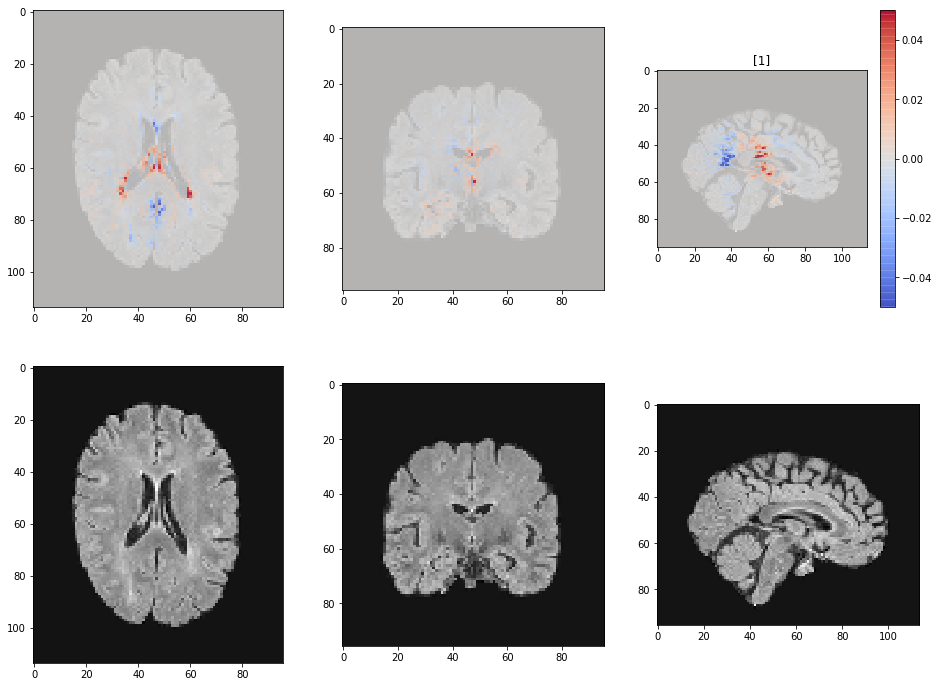

pred [0.] 
sigmoid score [0.36676332]
beheaded score -0.546127
analysis sum -0.611052


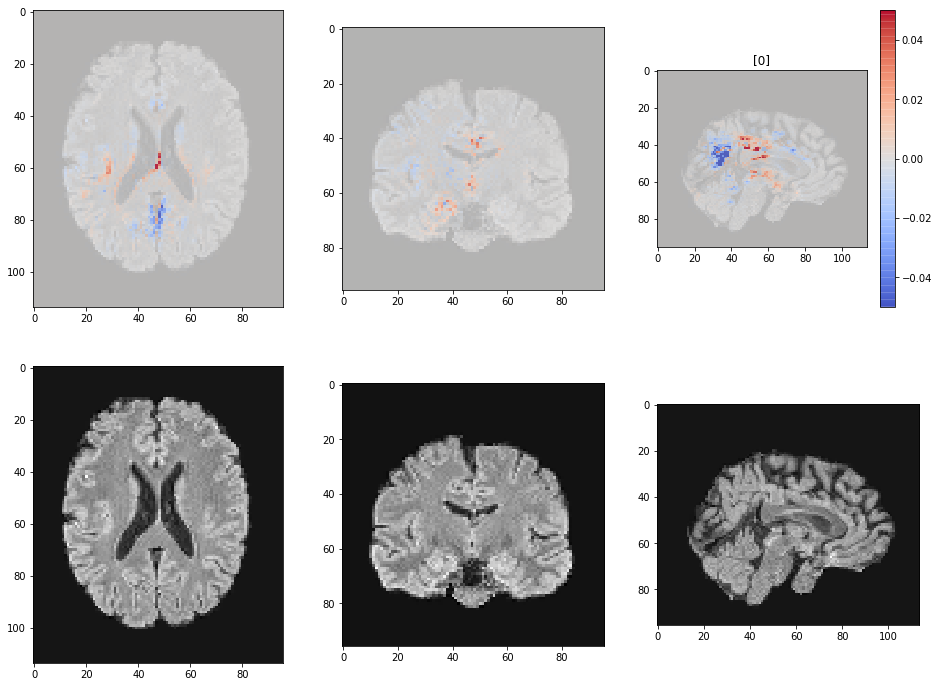

pred [1.] 
sigmoid score [0.6544661]
beheaded score 0.638729
analysis sum 1.263523


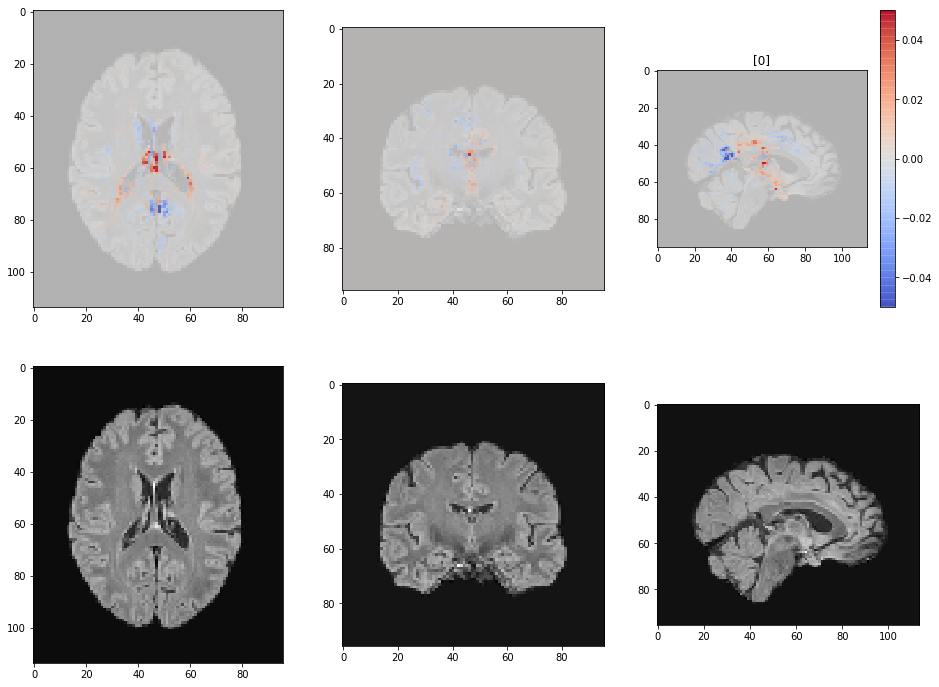

pred [0.] 
sigmoid score [0.27610388]
beheaded score -0.963871
analysis sum -1.569889


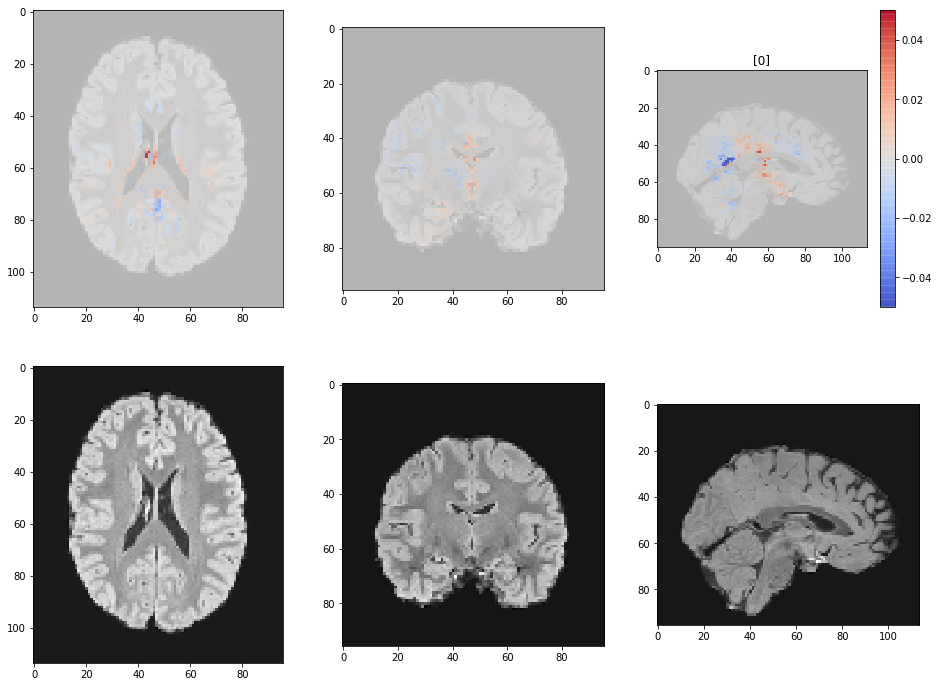

pred [1.] 
sigmoid score [0.9633791]
beheaded score 3.269826
analysis sum 4.172567


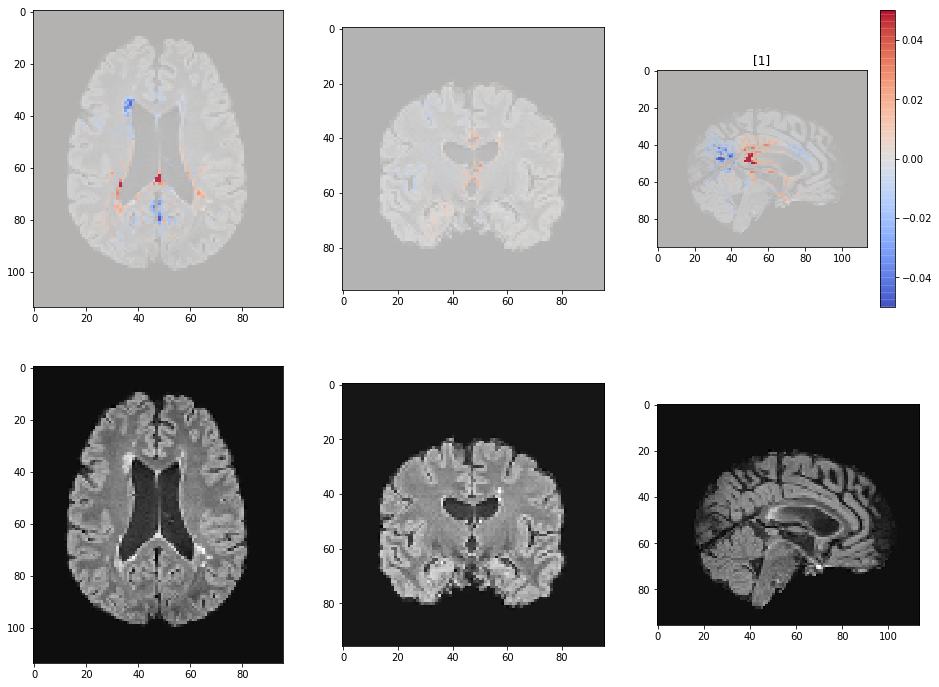

pred [0.] 
sigmoid score [0.09877317]
beheaded score -2.210931
analysis sum -2.669526


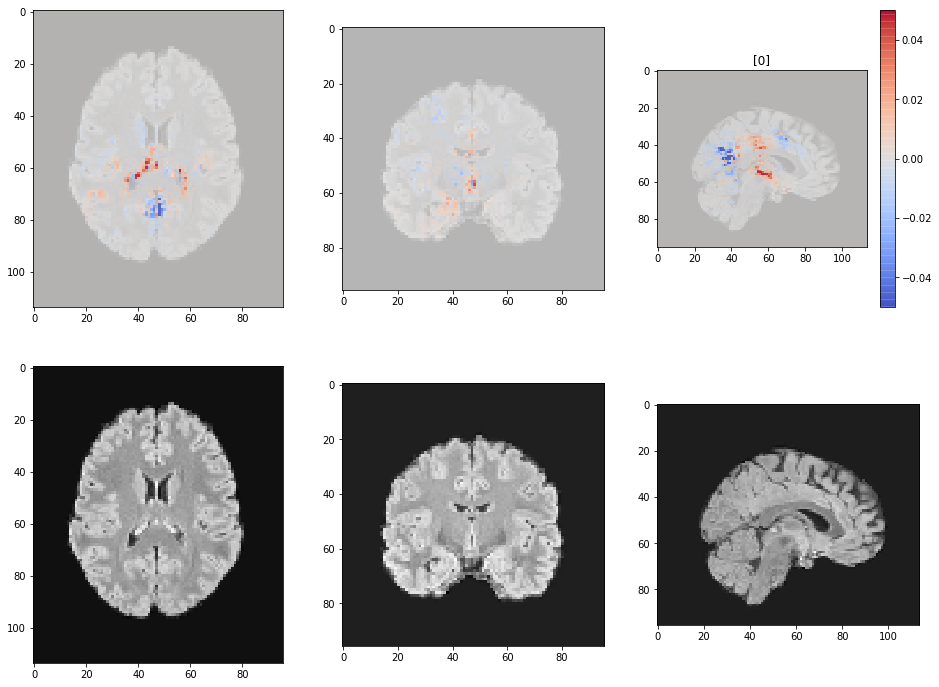

pred [0.] 
sigmoid score [0.27340817]
beheaded score -0.977399
analysis sum -1.177915


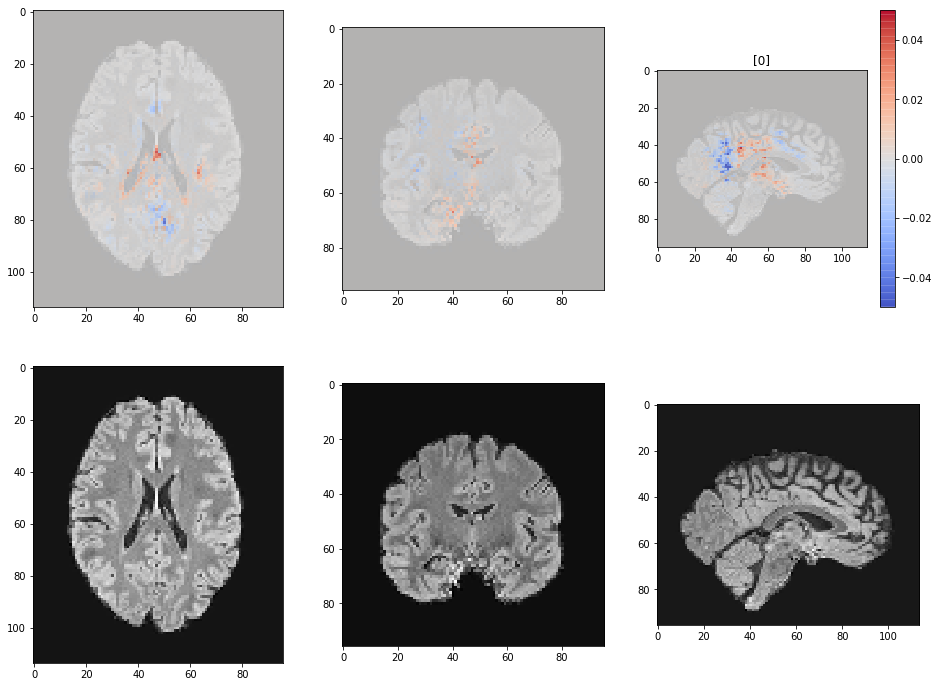

pred [1.] 
sigmoid score [0.86228323]
beheaded score 1.834385
analysis sum 2.327689


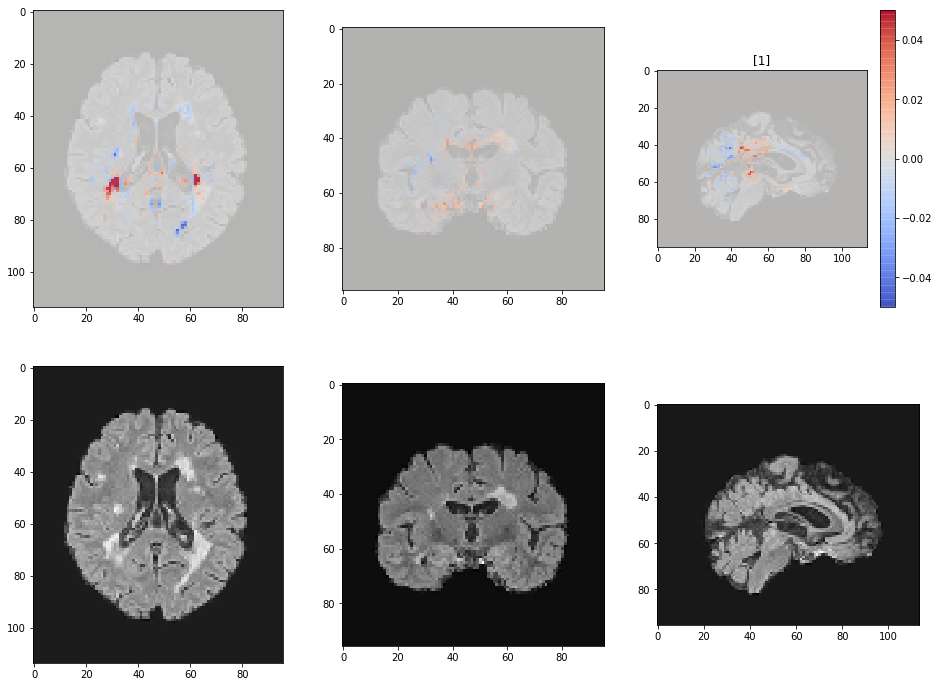

pred [0.] 
sigmoid score [0.45107046]
beheaded score -0.196346
analysis sum 0.141054


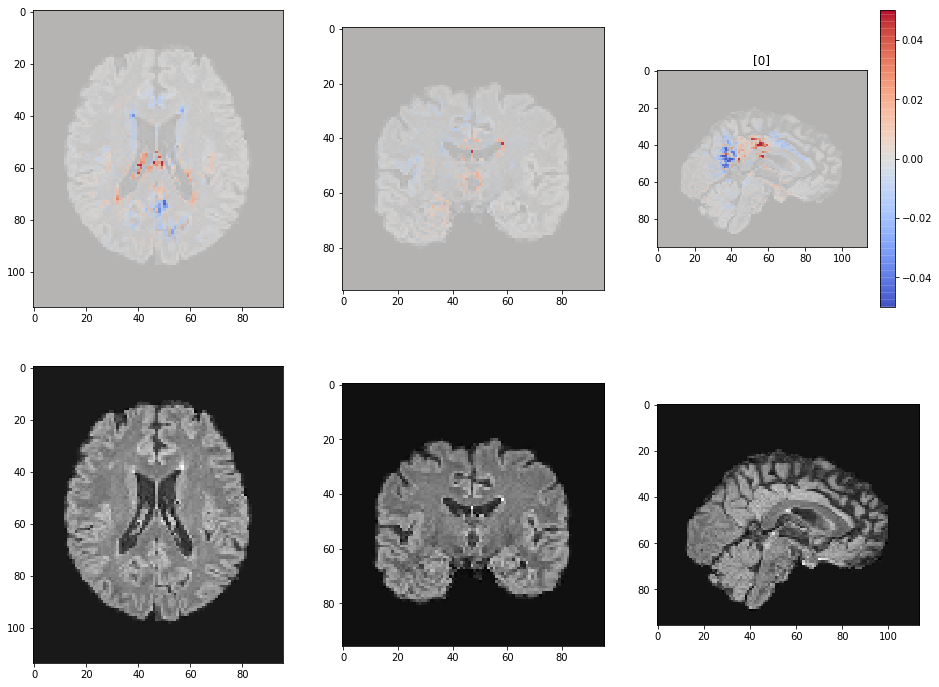

In [900]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", fine_tuned_beheaded_model)

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("fine_tuned_beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))
    plot_heatmap(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm')

# Averages pre-training vs scratch comparison

In [442]:
pre_trained_TP_heatmaps_holdout, pre_trained_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 0
zero 10


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [443]:
pre_trained_TP_heatmaps_train, pre_trained_TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 124
one 0
zero 61


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [444]:
fine_tuned_TP_heatmaps_holdout, fine_tuned_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 9


In [445]:
pre_trained_MS_heatmaps_holdout, pre_trained_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [446]:
fine_tuned_MS_heatmaps_holdout, fine_tuned_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [447]:
scratch_TP_heatmaps_holdout, scratch_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 6


In [448]:
scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [449]:
random_TP_heatmaps_holdout, random_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 13
zero 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


In [450]:
random_MS_heatmaps_holdout, random_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [478]:
def plot_heatmap_transfer_learning(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10., 4 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray')
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray')
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.07, 0.1, p2[2], 0.015]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
        
    
    # ensure colorbar is within plot
    #fig.subplots_adjust(bottom=0.2)
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [479]:
image_file_dir

'/analysis/fabiane/documents/publications/MS_CNN_VIS'

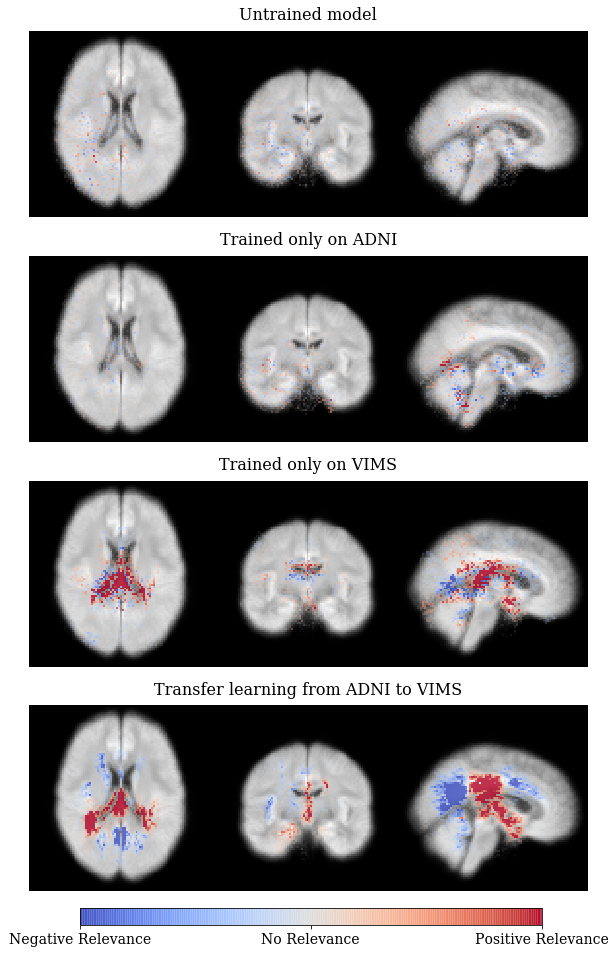

In [746]:
# use all classifications not just correct ones
hms = [random_MS_heatmaps_holdout * 20, pre_trained_MS_heatmaps_holdout * 20, scratch_MS_heatmaps_holdout, fine_tuned_MS_heatmaps_holdout]
titles = ["Untrained model", "Trained only on ADNI", "Trained only on VIMS", "Transfer learning from ADNI to VIMS"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_TransferLearning_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout * 15)
vmax = -vmin
#vmin = None
#vmax = None
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

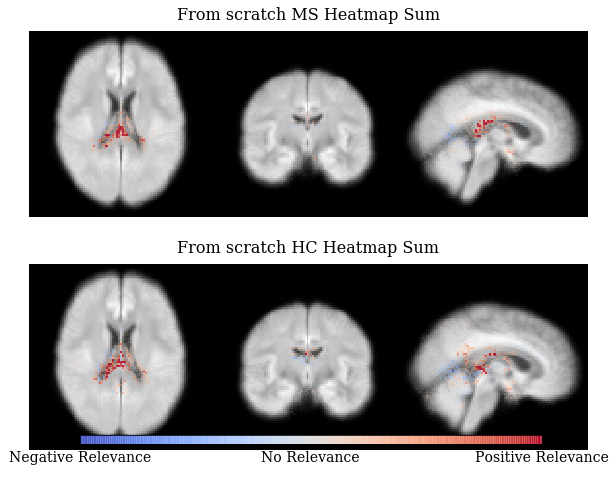

In [477]:
hms = [scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout]
titles = ["From scratch MS Heatmap Sum", "From scratch HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(scratch_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

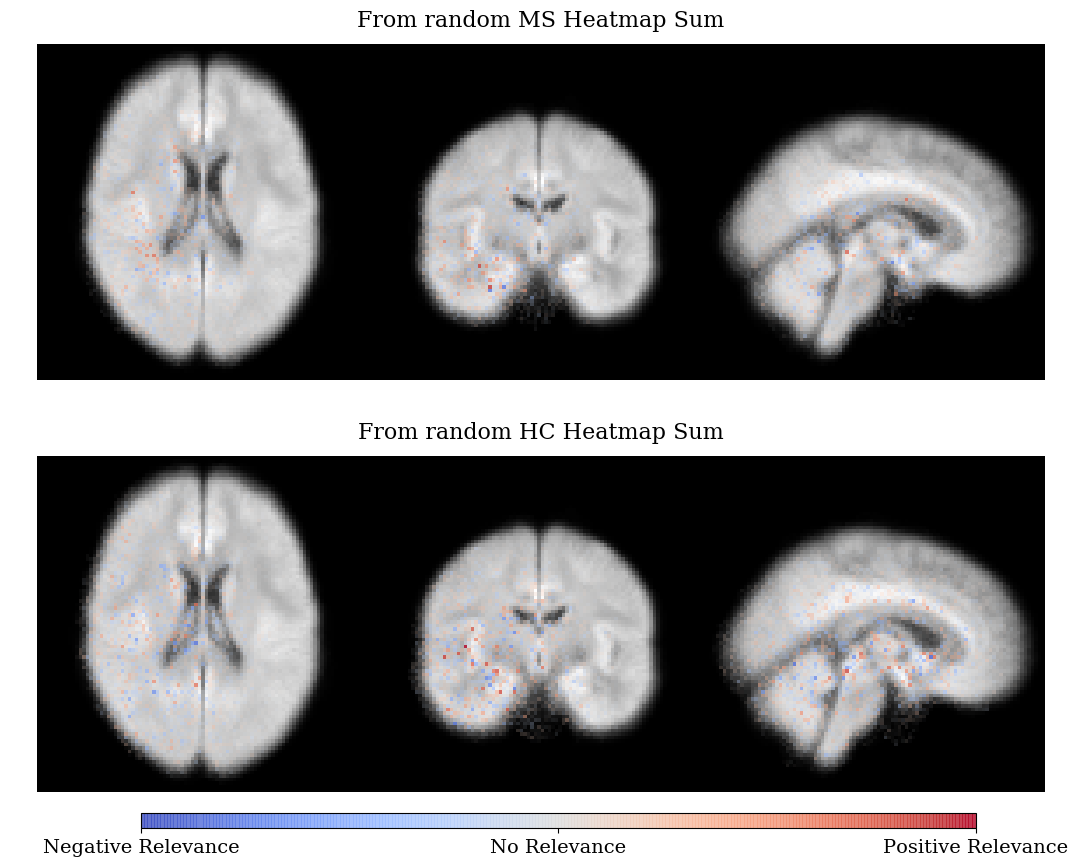

In [2327]:
hms = [random_MS_heatmaps_holdout, random_HC_heatmaps_holdout]
titles = ["From random MS Heatmap Sum", "From random HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

## Correlations

In [3256]:
def remove_nans_from_two_lists(former, latter, base="latter"):
    """ Remove nans from two arrays according to selected. """
    if base == "latter":
        slave = np.copy(former)
        master = np.copy(latter)
    elif base == "former":
        slave = np.copy(latter)
        master = np.copy(former)
    else:
        raise("Specify base as 'former' or 'latter'")
    
    not_nan_locs = np.where(~np.isnan(master))[0]
    print(len(not_nan_locs))
    master = master[~np.isnan(master)]
    slave = slave[not_nan_locs]
    
    if base == "latter":
        return slave, master
    elif base == "former":
        return master, slave

In [3314]:
def heatmap_lesion_similarity_sign(heatmap, lesions, sign="positive", plot=False):
    assert(heatmap.shape == lesions.shape)
    hm = np.copy(heatmap)
    lm = np.copy(lesions)
    sl = 48
    
    # check for missing lesion masks which are filled randomly
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill with NaNs")
        #plt.imshow(lesions[:,:,sl], cmap='gray')
        #plt.title("Random filled mask")
        #plt.show()
        similarity = np.NaN
    else:
        if sign == "positive":
            hm[hm<0.] = 0
        elif sign == "negative":
            hm[hm>0.] = 0
        l = lm * hm
        similarity = np.sum(l)
    
    if plot:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(lesions[:,:,sl], cmap='gray')
        #plt.imshow(hm[:,:,sl], cmap='Reds', alpha=0.6)
        plt.title("Lesion Mask")
        plt.subplot(1,2,2)
        plt.imshow(hm[:,:,sl], cmap='Reds')
        plt.title("Signed Heatmap")
        plt.show()
    
    similarity /= np.sum(hm)
    
    return similarity

### Correlation between relevance/lesion amount and EDSS

In [3361]:
train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None,
                         include_arbtr=True,
                         edss=np.array(edss_train)
                         )

test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None,
                         include_arbtr=True,
                         edss=np.array(edss_holdout)
                         )

In [3386]:
# Get heatmaps of all subjects
heatmap_list_holdout, edss_list_holdout = get_heatmap_list_with_edss(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
heatmap_list_train, edss_list_train = get_heatmap_list_with_edss(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Make lists for comparisons

In [3420]:
training_sim = []
training_lesion_sum = []
training_score_list = []
training_pred_list = []
training_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_train):
    lesions = lesion_masks_train[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_train[idx])
    training_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        training_lesion_sum.append(np.NaN)
    else:
        training_lesion_sum.append(np.sum(lesion_masks_train[idx]))
    score = fine_tuned_model.predict(train_loader[idx][0]).item()
    training_score_list.append(score)
    pred = int(score>= 0.5)
    training_pred_list.append(pred)
    # check if correctly classified
    if pred == train_loader[idx][1].item():
        training_true_pred_list.append(1)
    else:
        training_true_pred_list.append(0)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.


In [3426]:
holdout_sim = []
holdout_lesion_sum = []
holdout_score_list = []
holdout_pred_list = []
holdout_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_holdout):
    lesions = lesion_masks_holdout[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_holdout[idx])
    holdout_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        holdout_lesion_sum.append(np.NaN)
    else:
        holdout_lesion_sum.append(np.sum(lesion_masks_holdout[idx]))
    score = fine_tuned_model.predict(test_loader[idx][0]).item()
    holdout_score_list.append(score)
    pred = int(score >= 0.5)
    holdout_pred_list.append(pred)
    # check if correctly classified
    if pred == test_loader[idx][1].item():
        holdout_true_pred_list.appenfd(1)
    else:
        holdout_true_pred_list.append(0)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3389]:
# remove healthy controls from EDSS table
#edss_train = np.array(edss_train)
#edss_holdout = np.array(edss_holdout)

#train_patient_loc = np.where(np.array(y_train) == 1)
#holdout_patient_loc = np.where(np.array(y_holdout) == 1)

#edss_train_MS = edss_train[train_patient_loc]
#edss_holdout_MS = edss_holdout[holdout_patient_loc]

In [3428]:
# remove nans in both directions
tr_sim, edss_tr = remove_nans_from_two_lists(training_sim, edss_list_train, base="latter")
tr_sim, edss_tr = remove_nans_from_two_lists(tr_sim, edss_tr, base="former")

ho_sim, edss_ho = remove_nans_from_two_lists(holdout_sim, edss_list_holdout, base="latter")
ho_sim, edss_ho = remove_nans_from_two_lists(ho_sim, edss_ho, base="former")

58
56
13
13


In [3429]:
# correlation on training set
np.corrcoef(tr_sim, edss_tr)

array([[1.        , 0.30845045],
       [0.30845045, 1.        ]])

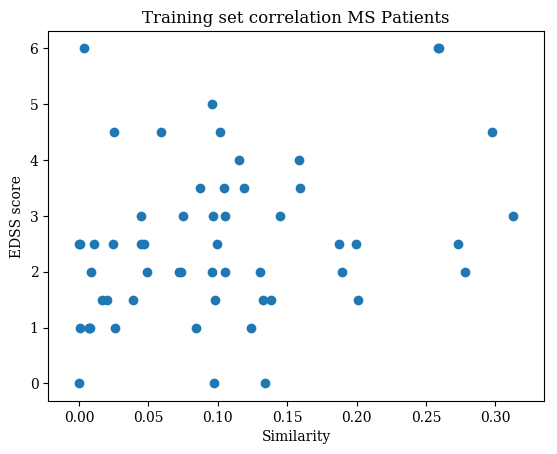

In [3430]:
# training set
plt.scatter(tr_sim, edss_tr)
plt.xlabel("Similarity")
plt.ylabel("EDSS score")
plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()

In [3431]:
# correlation on holdout set
np.corrcoef(ho_sim, edss_ho)

array([[ 1.        , -0.00577675],
       [-0.00577675,  1.        ]])

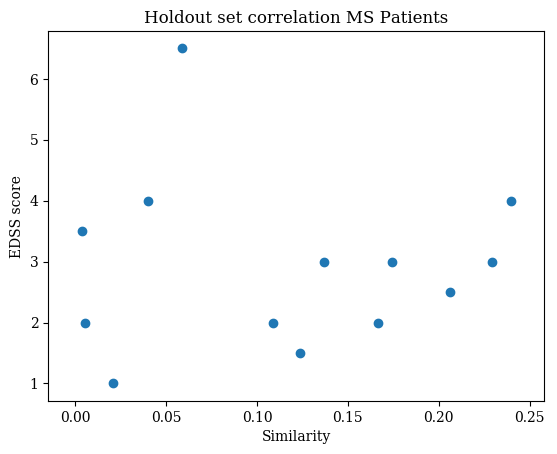

In [3432]:
# holdout set
plt.scatter(ho_sim, edss_ho)
plt.xlabel("Similarity")
plt.ylabel("EDSS score")
plt.title("Holdout set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()

In [3433]:
# correlation without highest two outliers
#tr_sim, edss_tr = np.concatenate([tr_sim[:np.argmax(tr_sim)], tr_sim[np.argmax(tr_sim)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_sim)], edss_tr[np.argmax(tr_sim)+1:]])
#tr_sim, edss_tr = np.concatenate([tr_sim[:np.argmax(tr_sim)], tr_sim[np.argmax(tr_sim)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_sim)], edss_tr[np.argmax(tr_sim)+1:]])
#np.corrcoef(tr_sim, edss_tr)

In [3434]:
# training set
#plt.scatter(tr_sim, edss_tr)
#plt.xlabel("Similarity")
#plt.ylabel("EDSS score")
#plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 200)
#plt.show()

### Correlation between lesion sum and EDSS

In [3435]:
# remove nans in both directions
tr_les, edss_tr = remove_nans_from_two_lists(training_lesion_sum, edss_list_train, base="latter")
tr_les, edss_tr = remove_nans_from_two_lists(tr_les, edss_tr, base="former")

ho_les, edss_ho = remove_nans_from_two_lists(holdout_lesion_sum, edss_list_holdout, base="latter")
ho_les, edss_ho = remove_nans_from_two_lists(ho_les, edss_ho, base="former")

58
56
13
13


In [3436]:
# correlation on training set
np.corrcoef(tr_les, edss_tr)

array([[1.        , 0.31938496],
       [0.31938496, 1.        ]])

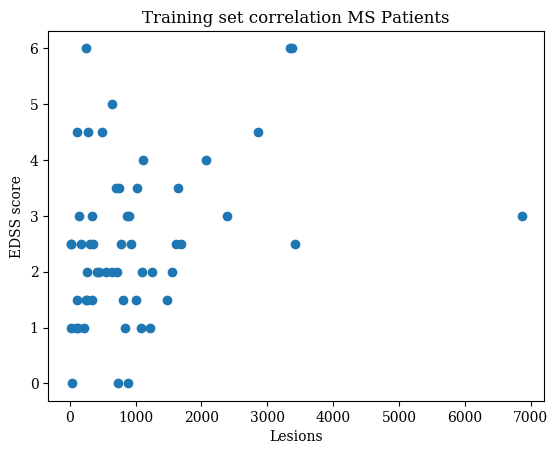

In [3437]:
# training set
plt.scatter(tr_les, edss_tr)
plt.xlabel("Lesions")
plt.ylabel("EDSS score")
plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()

In [3438]:
# correlation without highest outlier
np.corrcoef(np.concatenate([tr_les[:np.argmax(tr_les)], tr_les[np.argmax(tr_les)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_les)], edss_tr[np.argmax(tr_les)+1:]]))

array([[1.       , 0.3953995],
       [0.3953995, 1.       ]])

In [3439]:
# correlation on holdout set
np.corrcoef(ho_les, edss_ho)

array([[1.        , 0.01516586],
       [0.01516586, 1.        ]])

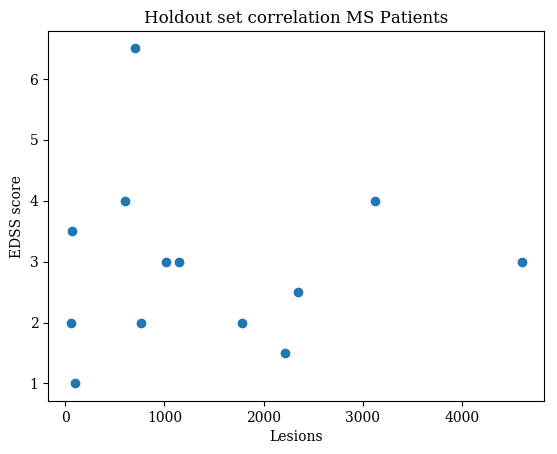

In [3440]:
# holdout set
plt.scatter(ho_les, edss_ho)
plt.xlabel("Lesions")
plt.ylabel("EDSS score")
plt.title("Holdout set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()

### Correlation between lesion amount and prediction/score

In [3441]:
# remove nans in both directions
tr_les, pred_tr = remove_nans_from_two_lists(training_lesion_sum, training_pred_list, base="former")
tr_les, score_tr = remove_nans_from_two_lists(training_lesion_sum, training_score_list, base="former")
tr_les, true_pred_tr = remove_nans_from_two_lists(training_lesion_sum, training_true_pred_list, base="former")

120
120
120


In [3442]:
# correlation on training set
np.corrcoef(tr_les, pred_tr)

array([[1.        , 0.51050549],
       [0.51050549, 1.        ]])

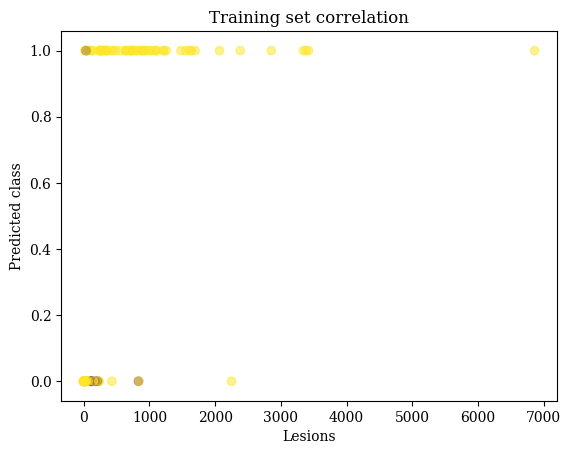

In [3453]:
# training set
plt.scatter(tr_les, pred_tr, c=true_pred_tr, alpha=0.5)
plt.xlabel("Lesions")
plt.ylabel("Predicted class")
plt.title("Training set correlation")
#plt.xlim(-50, 130)
plt.show()

In [3444]:
# correlation on training set
np.corrcoef(tr_les, score_tr)

array([[1.        , 0.60596496],
       [0.60596496, 1.        ]])

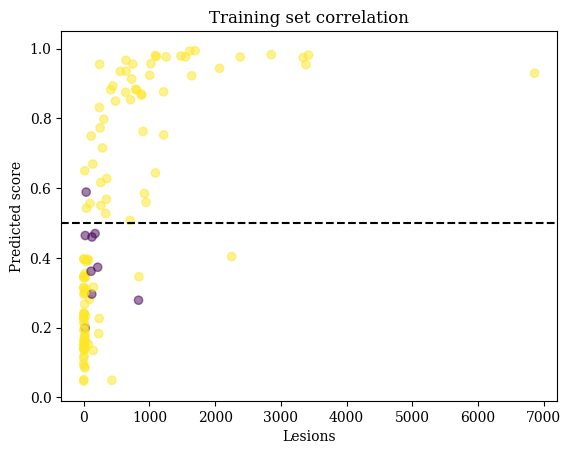

In [3489]:
# training set
plt.scatter(tr_les, score_tr, c=true_pred_tr, alpha=0.5)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xlabel("Lesions")
plt.ylabel("Predicted score")
plt.title("Training set correlation")
#plt.legend("true", "false")
#plt.xlim(-50, 130)
plt.show()

In [3464]:
# remove nans in both directions
ho_les, pred_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_pred_list, base="former")
ho_les, score_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_score_list, base="former")
ho_les, true_pred_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_true_pred_list, base="former")

23
23
23


In [3465]:
# correlation on hoaining set
np.corrcoef(ho_les, pred_ho)

array([[1.        , 0.56655065],
       [0.56655065, 1.        ]])

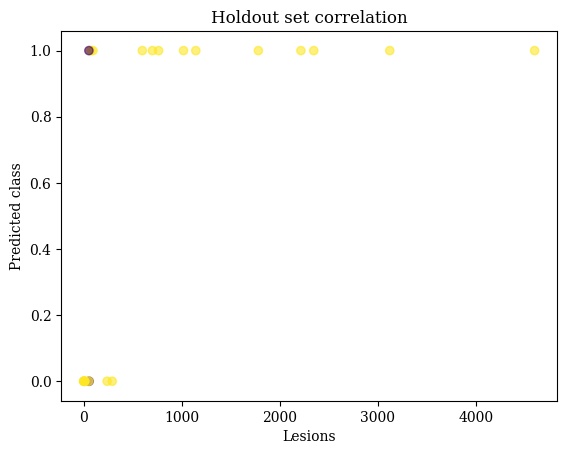

In [3466]:
# hoaining set
plt.scatter(ho_les, pred_ho, c=true_pred_ho, alpha=0.6)
plt.xlabel("Lesions")
plt.ylabel("Predicted class")
plt.title("Holdout set correlation")
#plt.xlim(-50, 130)
plt.show()

In [3412]:
# holdout

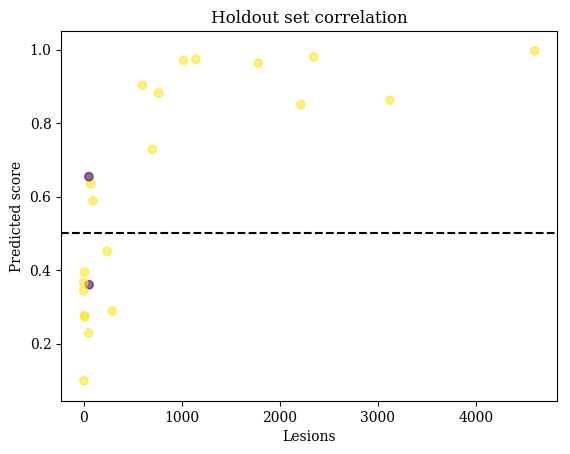

In [3488]:
# holdout set
plt.scatter(ho_les, score_ho, c=true_pred_ho, alpha=0.6)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xlabel("Lesions")
plt.ylabel("Predicted score")
plt.title("Holdout set correlation")
#plt.xlim(-50, 130)
plt.show()

### Correlation between relevance and lesion amount

In [3285]:
# Get all heatmaps of both HC and MS
heatmap_list_holdout = get_heatmap_list(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
heatmap_list_train = get_heatmap_list(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3289]:
individual_relevance_sum = []
individual_lesion_sum = []
for relevance, lesions in zip(heatmap_list_train, lesion_masks_train):
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, skip.")
    else:
        individual_relevance_sum.append(np.sum(relevance))
        individual_lesion_sum.append(np.sum(lesions))

Current lesion mask not available, skip.
Current lesion mask not available, skip.
Current lesion mask not available, skip.
Current lesion mask not available, skip.


Text(0, 0.5, 'Relevance sum')

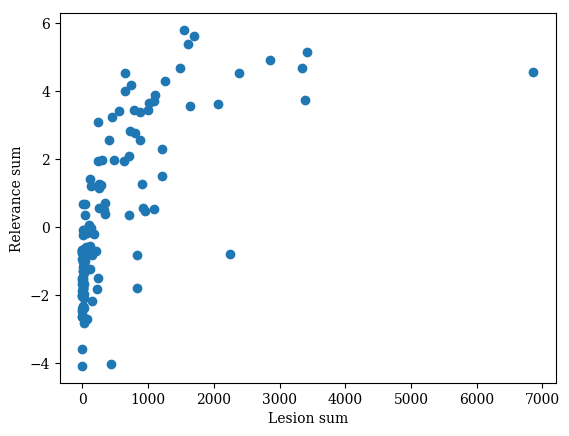

In [3294]:
plt.scatter(individual_lesion_sum, individual_relevance_sum)
plt.xlabel("Lesion sum")
plt.ylabel("Relevance sum")
#plt.xlim(-50, 8000)

In [3291]:
np.corrcoef(individual_lesion_sum, individual_relevance_sum)

array([[1.        , 0.65611735],
       [0.65611735, 1.        ]])

In [3300]:
# correlation without highest outlier
np.corrcoef(np.concatenate([individual_lesion_sum[:np.argmax(individual_lesion_sum)], individual_lesion_sum[np.argmax(individual_lesion_sum)+1:]]), np.concatenate([individual_relevance_sum[:np.argmax(individual_lesion_sum)], individual_relevance_sum[np.argmax(individual_lesion_sum)+1:]]))

array([[1.        , 0.71970984],
       [0.71970984, 1.        ]])

In [3301]:
# correlation without highest two outliers
#individual_lesion_sum, individual_relevance_sum = np.concatenate([individual_lesion_sum[:np.argmax(individual_lesion_sum)], individual_lesion_sum[np.argmax(individual_lesion_sum)+1:]]), np.concatenate([individual_relevance_sum[:np.argmax(individual_lesion_sum)], individual_relevance_sum[np.argmax(individual_lesion_sum)+1:]])
#individual_lesion_sum, individual_relevance_sum = np.concatenate([individual_lesion_sum[:np.argmax(individual_lesion_sum)], individual_lesion_sum[np.argmax(individual_lesion_sum)+1:]]), np.concatenate([individual_relevance_sum[:np.argmax(individual_lesion_sum)], individual_relevance_sum[np.argmax(individual_lesion_sum)+1:]])
#np.corrcoef(individual_lesion_sum, individual_relevance_sum)

In [3302]:
#plt.scatter(individual_lesion_sum, individual_relevance_sum)
#plt.xlabel("Lesion sum")
#plt.ylabel("Relevance sum")

### Relevance vs EDSS

In [747]:
heatmap_list_train, edss_list_train = get_heatmap_list_with_edss(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=True)
individual_relevance_sum = [np.sum(relevance) for relevance in heatmap_list_train]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


IndexError: tuple index out of range

In [ ]:
individual_relevance_sum, edss_list_train = remove_nans_from_two_lists(individual_relevance_sum, edss_list_train, base="latter")

In [ ]:
np.corrcoef(individual_relevance_sum, edss_list_train)

In [ ]:
plt.scatter(individual_relevance_sum, edss_list_train)
plt.xlabel("Relevance sum")
plt.ylabel("EDSS score")

In [ ]:
print("Calculate positive training similarity")
pos_training_sim = []
for idx, heatmap in enumerate(heatmap_list_train):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_train[idx], sign="positive", plot=False)
    #similarity /= (np.sum(lesion_masks_train[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)    
    #similarity /= (np.sum(hm) + 1e-6)
    pos_training_sim.append(similarity)

print("Calculate negative training similarity")
neg_training_sim = []
for idx, heatmap in enumerate(heatmap_list_train):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_train[idx], sign="negative", plot=False)
    #similarity /= (np.sum(lesion_masks_train[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)
    #similarity /= (np.sum(hm) + 1e-6)
    neg_training_sim.append(similarity)

In [ ]:
train_labels = np.array(y_train)

In [748]:
ms_sim_pos = []
for sim, y in zip(pos_training_sim, train_labels):
    if y == 1:
        ms_sim_pos.append(sim)
        
ms_sim_neg = []
for sim, y in zip(neg_training_sim, train_labels):
    if y == 1:
        ms_sim_neg.append(sim)

NameError: name 'pos_training_sim' is not defined

In [3324]:
ms_sim_pos

[0.04914334872228872,
 0.02563970516219168,
 0.095677800689292,
 0.0005478932800094307,
 0.09568868723047348,
 0.2782842901902544,
 0.10492307559666719,
 0.159224369810055,
 0.31275488006002267,
 0.1992067963311656,
 0.05942872512253358,
 0.1052648742845987,
 0.07342239204368464,
 0.009002650642215766,
 0.09687890439637249,
 0.03904933853239539,
 0.07459452694634724,
 0.1587225707189453,
 0.08074916065973985,
 0.0977764664831652,
 0.04462500300114147,
 nan,
 0.020500939744547777,
 nan,
 0.11506413881711317,
 0.008245593418391478,
 0.2010922215173634,
 0.13223229962897154,
 0.003549184469961043,
 0.1893396812374096,
 0.006991251232754949,
 0.13845989257574937,
 0.0006251866480937922,
 0.2583846200506287,
 0.07583245836445635,
 0.007561883419687145,
 0.04490835270017205,
 0.04691210786440794,
 0.27282937956464126,
 0.10149655200518203,
 0.07198871422355949,
 0.08688733577112762,
 0.14459430918026292,
 0.2973456055816811,
 0.0993342141916684,
 0.1872441882650388,
 0.00010460086497845314,


In [3469]:
np.nanmean(ms_sim_pos)

0.09704111024853873

In [3470]:
np.nanstd(ms_sim_pos)

0.0809105705686465

On holdout

In [3494]:
heatmap_list_holdout, edss_list_holdout = get_heatmap_list_with_edss(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=True)
individual_relevance_sum = [np.sum(relevance) for relevance in heatmap_list_holdout]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3495]:
individual_relevance_sum, edss_list_holdout = remove_nans_from_two_lists(individual_relevance_sum, edss_list_holdout, base="latter")

13


In [3496]:
np.corrcoef(individual_relevance_sum, edss_list_holdout)

array([[ 1.        , -0.03564663],
       [-0.03564663,  1.        ]])

Text(0, 0.5, 'EDSS score')

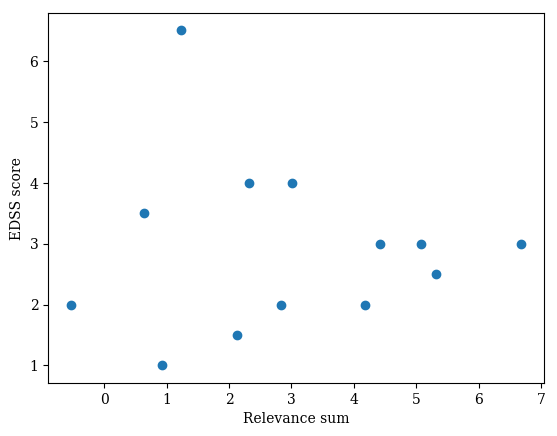

In [3497]:
plt.scatter(individual_relevance_sum, edss_list_holdout)
plt.xlabel("Relevance sum")
plt.ylabel("EDSS score")

In [3498]:
print("Calculate positive holdout similarity")
pos_holdout_sim = []
for idx, heatmap in enumerate(heatmap_list_holdout):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_holdout[idx], sign="positive", plot=False)
    #similarity /= (np.sum(lesion_masks_holdout[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)    
    #similarity /= (np.sum(hm) + 1e-6)
    pos_holdout_sim.append(similarity)

print("Calculate negative holdout similarity")
neg_holdout_sim = []
for idx, heatmap in enumerate(heatmap_list_holdout):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_holdout[idx], sign="negative", plot=False)
    #similarity /= (np.sum(lesion_masks_holdout[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)
    #similarity /= (np.sum(hm) + 1e-6)
    neg_holdout_sim.append(similarity)

Calculate positive holdout similarity
Calculate negative holdout similarity


In [3499]:
holdout_labels = np.array(y_holdout)

In [3500]:
ms_sim_pos = []
for sim, y in zip(pos_holdout_sim, holdout_labels):
    if y == 1:
        ms_sim_pos.append(sim)
        
ms_sim_neg = []
for sim, y in zip(neg_holdout_sim, holdout_labels):
    if y == 1:
        ms_sim_neg.append(sim)

In [3501]:
ms_sim_pos

[0.020796955514751903,
 0.0036047617259195863,
 0.005672487221012876,
 0.018325352914694972,
 0.08133680455116768,
 0.07558575254387463,
 0.02614059339635333,
 0.019506992245761298,
 0.023612326375248297]

In [3502]:
np.nanmean(ms_sim_pos)

0.0305091140543094

In [3503]:
np.nanstd(ms_sim_pos)

0.02663858117208067